# Rent Prediction 

## Executive Summary

The aim of this work is to obtain a model for estimating the net rental price. For this purpose, a detailed data control and analysis was carried out. The best linear model based on the data was calculated using the best subset method. Adding interaction terms could not lead to any improvement in the model.

The model has the following problems: On the one hand, there are inhomogeneous variances. However, for this model, attempting to fix this problem resulted in poorer results. On the other hand, some outliers could be identified in the data. Due to a lack of basis in terms of content to remove them, they are kept in the model.

For these reasons, a linear model with all variables provided is recommended for estimating the net rental price.

# Data Analysis

The results of the data control, data changes, uni-, bi- and trivariate analyzes are presented below. 

## Data Control

The dataset contains a total of 1000 observations of a total of 11 different variables. In the first step, a formal data control was carried out. No errors were found in the data. Specifically, missing and impossible values, correct data formats and whether all values correspond to the theoretically possible. This is not a content check, this is done in the next section.

## Data Transformations
### Construction Year
The dataset contains the variable "year of construction" for which the following changes were made: 1) For better interpretability, this was recoded to "age". The age corresponds to the difference between the year 2003 and the year the apartment was built. 2) Age is summarized in blocks of 20 years. The last block, "(80, 80+]" includes all apartments that are 80 or more years old.

There are two abnormalities with the variable. On the one hand, 199 apartments were built in 1918 and none after. This suggests that all dwellings built in 1918 or earlier were assigned to this year of construction. On the other hand, two apartments were not assigned to a whole year like all the others, but were numbered in the respective half of the year (e.g. 14.5 years). Both points can be handled by summarizing them into 20 annual blocks. Furthermore, one can assume that year-to-year differences should not have a significant impact on the apartment price. In total, a summary in 20 year blocks is justified.

### Condominium
The dataset contains two variables "Good Housing Development" and "Best Housing Development". Since no apartment is included in both categories, we combine both variables and call them "apartment complex". This consists of three categories: "Normal residential complex", "Good residential complex" and "Best residential complex". "Normal residential complex" are all those not included in the other two categories.

### Renames
The data set contains the variables: "Hot water supply included", "Central heating available" and "Tiled bathroom". These three variables are coded in an atypical way because "No" is assigned the value "1" and "Yes" the value "0". Usually, the coding is done in reverse, as was done with the other binary variables (variables that only take two values) in the data set. In order to ensure an unambiguous interpretation of the variables, the three mentioned are renamed "Without hot water supply included", "Without central heating available" and "Without tiled bathroom". So we can again interpret the value "1" as "yes" and the "0" as "no".

## Univariate Analysis

In [60]:
# import libraries
library(readxl)
library(xtable)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(reshape2)
library(nlme)
library(lmtest)
library(sandwich)
library(rpart)
library(rpart.plot)
library(gridExtra)
options(scipen = 1e+9)
path <- "./data.xlsx"

# read data
rent <- read_xlsx(path, sheet = 2)

# rename variables
names(rent) <- c(
  "Rent", "Area", "Rooms", "Constr_Year", "Good_Resid_Compl", "Best_Resid_Compl", "Warm_Water_Supp", "Centr_Heating", "Tiled_Bath", "Add_Equip_Bath", "Elevated_Kitchen")


# test if variable is binary
is_binary <- function(x) x == 0 | x == 1

# control for errors
daten_kontrolle <- function(daten = rent){
  # missing values?
  missing_values <- any(is.na(daten))

  # no numbers?
  no_numb <- any(apply(daten, 2, is.nan))

  # all numeric?
  all_numeric <- all(apply(daten, 2, is.numeric))

  # check for negative values
  neg_values <- any(daten < 0)

  # alle anderen variablen haben nur null und eins als definitionsbereich. dies laesst sich leicht testen
  all_binary <- all(apply(daten[,5:ncol(daten)], 2, function(x) all(is_binary(x))))

  # teste ob alle bedingungen erfuellt sind
  !missing_values & !no_numb & all_numeric & !neg_values & all_binary
}

if(!daten_kontrolle(rent)) warning("There are errors in the data.")

nr <- rent["Rent"]
nr <- pull(nr) 
area <- rent["Area"]
area <- pull(area) 
rooms <- rent["Rooms"]
rooms <- pull(rooms) 
bj <- rent["Constr_Year"]
bj <- pull(bj) 
age <- 2003 - bj
res_cmpx_good <- rent["Good_Resid_Compl"]
res_cmpx_good <- pull(res_cmpx_good)
res_cmpx_best <- rent["Best_Resid_Compl"]
res_cmpx_best <- pull(res_cmpx_best)

# folgende drei variablen sind ungewohnlich kodiert in dem sinne dass 0 fuer ja und 1 fuer nein steht
# wir schaffen somit drei neue variablen die wir als negierte originale, dh warmwasserversorgung -> keine warmwasserversorgung etc benennen
ww0 <- rent["Warm_Water_Supp"]
ww0 <- pull(ww0)
no_ww0 <- ww0

ch0 <- rent["Centr_Heating"]
ch0 <- pull(ch0)
no_ch0 <- ch0

tiled_bath <- rent["Tiled_Bath"]
tiled_bath <- pull(tiled_bath)
no_tiled_bath <- tiled_bath

# durchschn_area <- area / rooms

# wir schaffen eine neue variable Wohnqualitaet die aus drei Gruppen besteht,
# "Normal" fuer alle wohnungen die nicht in res_cmpx_good oder res_cmpx_best sind
# "Gut" fuer alle wohnungen die in "res_cmpx_good sind"
# "Beste" fuer die wohnungen die in res_cmpx_best sind aber wir muessen auf ueberschneidungen zwischen res_cmpx_good und res_cmpx_best aufpassen
which(res_cmpx_good == 1 & res_cmpx_best == 1)
# gibt keine 

# also wenn eine wohnung nicht in res_cmpx_good oder res_cmpx_best dann sagen wir sie ist normal
# which(res_cmpx_good == 0 & res_cmpx_best == 0)
res_cmplx_norm <- ifelse(res_cmpx_good == 0 & res_cmpx_best == 0, 1, 0)
res_cmplx <- ifelse(res_cmplx_norm == 1, 1, ifelse(res_cmpx_good == 1, 2, 3))
res_cmplx <- factor(res_cmplx, labels = c("Normal", "Gut", "Beste"))

bath_extra <- rent["Add_Equip_Bath"]
bath_extra <- pull(bath_extra)
kitchen_elev <- rent["Elevated_Kitchen"]
kitchen_elev <- pull(kitchen_elev)       

# speicher alten rent datensatz
rent_old <- rent

# schaffe neuen mit transformierten daten
rent <- data.frame(
  Rent = nr,
  Area = area, 
  Rooms = rooms,
  Age_Grouped = cut(2003-rent_old$Constr_Year, breaks = c(0, 20, 40, 60, 80, Inf), labels = c("(0,20]","(20,40]",  "(40,60]",  "(60,80]", "(80,80+]")), 
  Resid_Complex = res_cmplx,
  No_WWSupply = no_ww0,
  No_Centr_Heat = no_ch0,
  No_Tiled_Bath = no_tiled_bath,
  Elev_Bath = bath_extra,
  Elev_Kitchen = kitchen_elev
)
# rename levels of Resid_Complex
levels(rent$Resid_Complex) <- list("Good" = "Gut", "Normal" = "Normal", "Best" = "Beste")

head(rent)

integer(0)

,Rent,Area,Rooms,Age_Grouped,Resid_Complex,No_WWSupply,No_Centr_Heat,No_Tiled_Bath,Elev_Bath,Elev_Kitchen
,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,741.39,68,2,"(80,80+]",Good,0,0,0,0,0
2,715.82,65,2,"(0,20]",Good,0,0,0,0,0
3,528.25,63,3,"(80,80+]",Good,0,0,0,0,0
4,553.99,65,3,"(0,20]",Normal,0,0,0,1,0
5,698.21,100,4,"(0,20]",Good,0,0,0,1,1
6,935.65,81,4,"(20,40]",Normal,0,0,0,0,0


### Rent

Diagram 1 (top) shows a symmetrical distribution of the net rents with a few outliers (black dots). Chart 2 (middle) reflects the number of apartments in the corresponding net rent intervals: 50.1% of the apartments has a rent between 392-699 and a quarter is below and above . The interval length increases towards the edges. The final interval, the top 50 dwellings (5%), roughly corresponds to the merging of the first three intervals (0-699). Chart 3 (bottom) shows the cumulative frequency of net rents. It can be seen that 55.4% of the apartments have a net rental price less than or equal to 575.

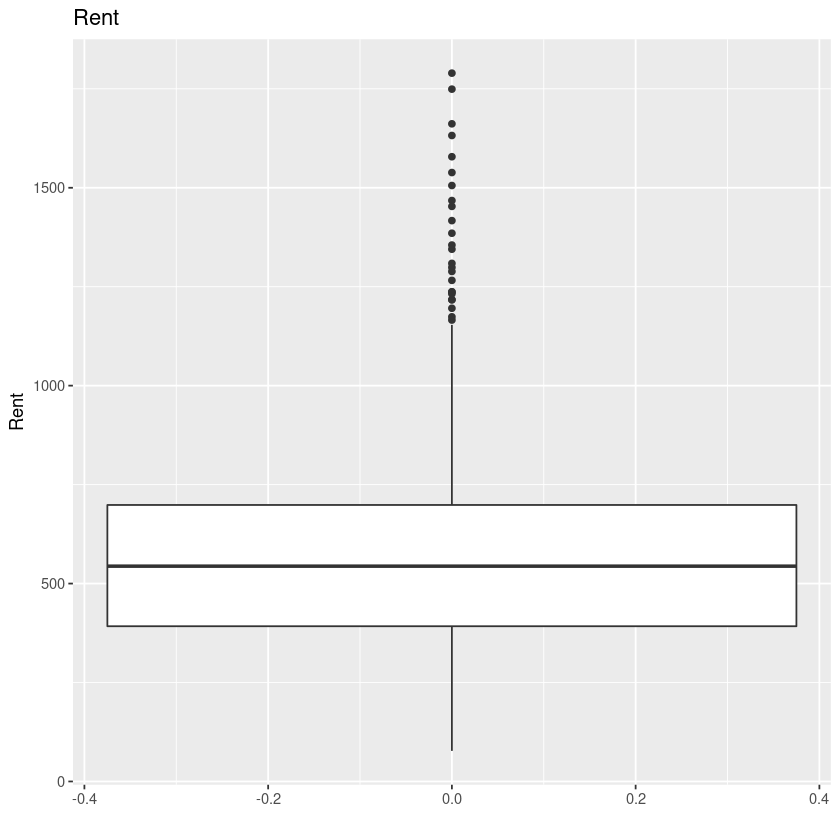

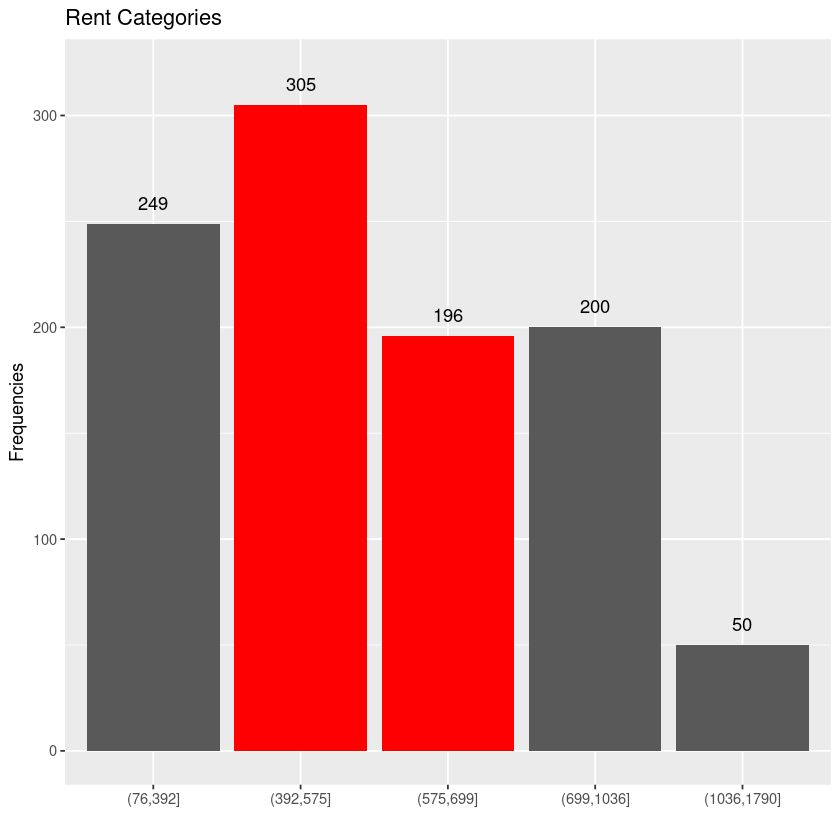

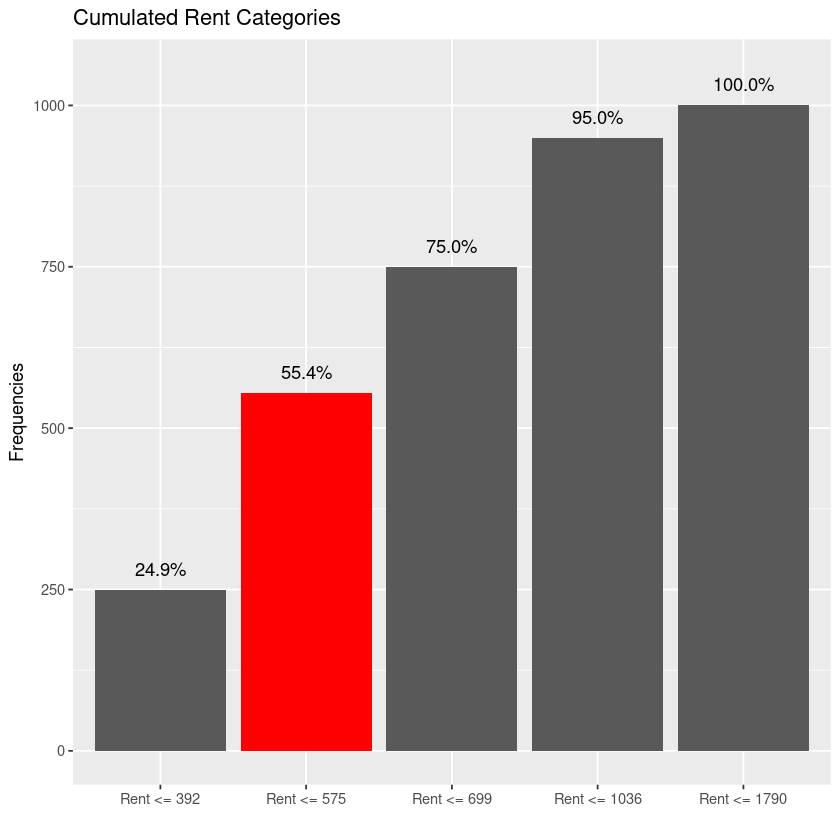

In [42]:
nm <- rent$Rent
nm_stats <- c(round(min(nm)-1), round(quantile(nm, 0.25)), round(mean(nm)), round(quantile(nm, 0.75)), round(quantile(nm, 0.95)), round(max(nm)))

cat_nm <- cut(nm, nm_stats, dig.lab = 5)

# anzahl an beobachtungen in den jeweiligen kategorien
table_nm_cat <- table(cat_nm)

# speicher im df fuer die grafische aufbearbeitung
df_nm <- data.frame(table_nm_cat)

# cumsums
cumsum_cat_nm <- cumsum(table_nm_cat)
names(cumsum_cat_nm) <- paste("Rent <=", nm_stats[-1])
df_cumsum_nm <- data.frame(Cat = names(cumsum_cat_nm), Freq = cumsum_cat_nm)

# boxplot: einige ausreisser nach oben
ggplot(rent) + geom_boxplot(aes(y = nm)) + labs(title = "Rent", x=" ", y="Rent") 

# histogram
# ggplot(miete) + geom_histogram(aes(x = nm), bins = 10) + labs(title = "Rent", x="Rent", y="Anzahl")
ggplot(df_nm, aes(x=cat_nm, y = Freq)) + geom_bar(stat = "identity", fill = c("grey35", "red", "red", "grey35", "grey35")) + geom_text(aes(label = Freq), vjust = -1 ) + labs(title="Rent Categories",
        x =" ", y = "Frequencies")+ ylim(c(0, 320)) 

# kummulierte haeufigkeiten
df_cumsum_nm %>% arrange(Freq) %>% mutate(name = factor(Cat, levels=names(cumsum_cat_nm))) %>% ggplot(aes(x=name, y = Freq, label = scales::percent(Freq/1000))) + geom_bar(stat = "identity", fill = c("grey35", "red", "grey35", "grey35", "grey35")) + geom_text(vjust = -1) + labs(title="Cumulated Rent Categories", x =" ", y = "Frequencies")+ ylim(c(0, 1050)) 



### Area

The average living area is: 71 square meters (qm). Graph 1 (top) indicates a symmetrical distribution of the data with some outliers. Graph 2 (middle) shows the absolute frequencies. The number of apartments decreases as the area increases. Furthermore, the scattering towards the edges increases more and more. 48.2% of apartments are concentrated on the interval of 55-85 sq.m. (bars marked in red). More than half (54%) of the apartments are 71 square meters or less (Graph 3, bottom).

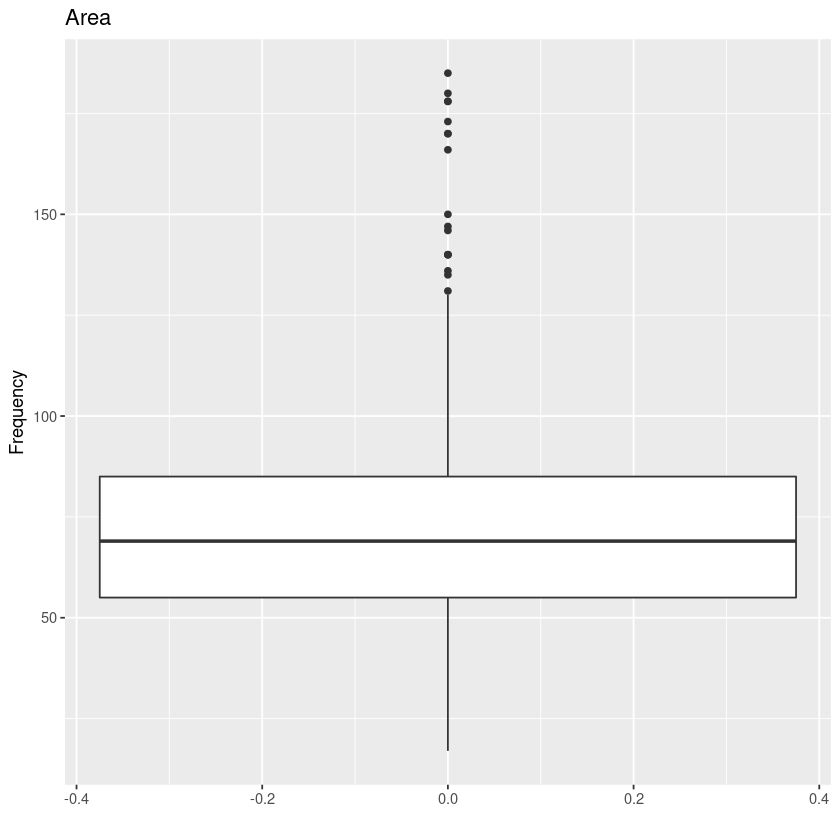

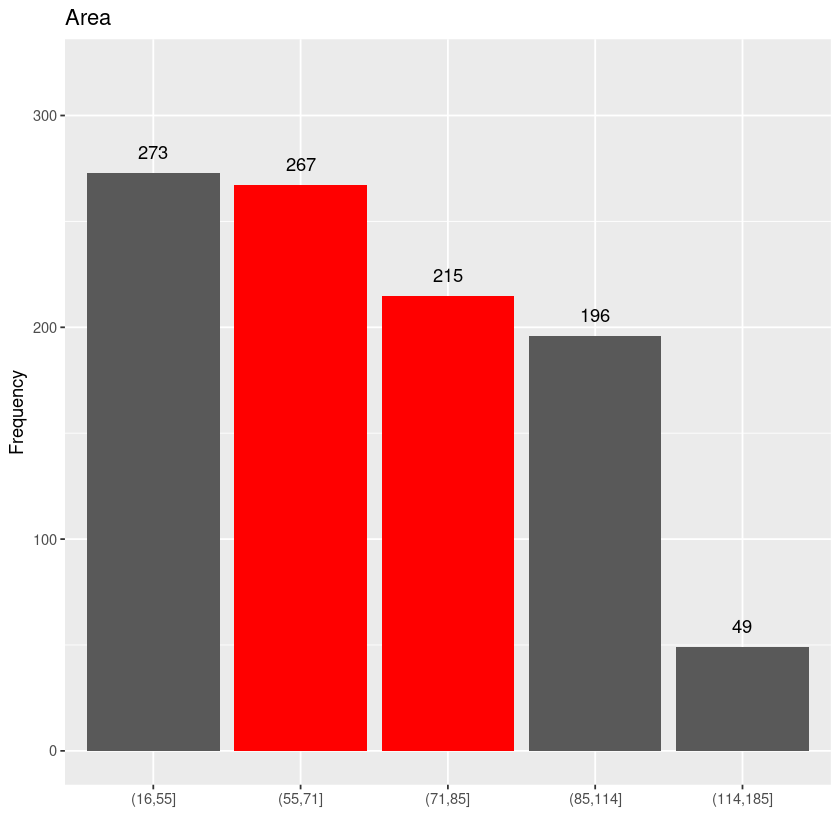

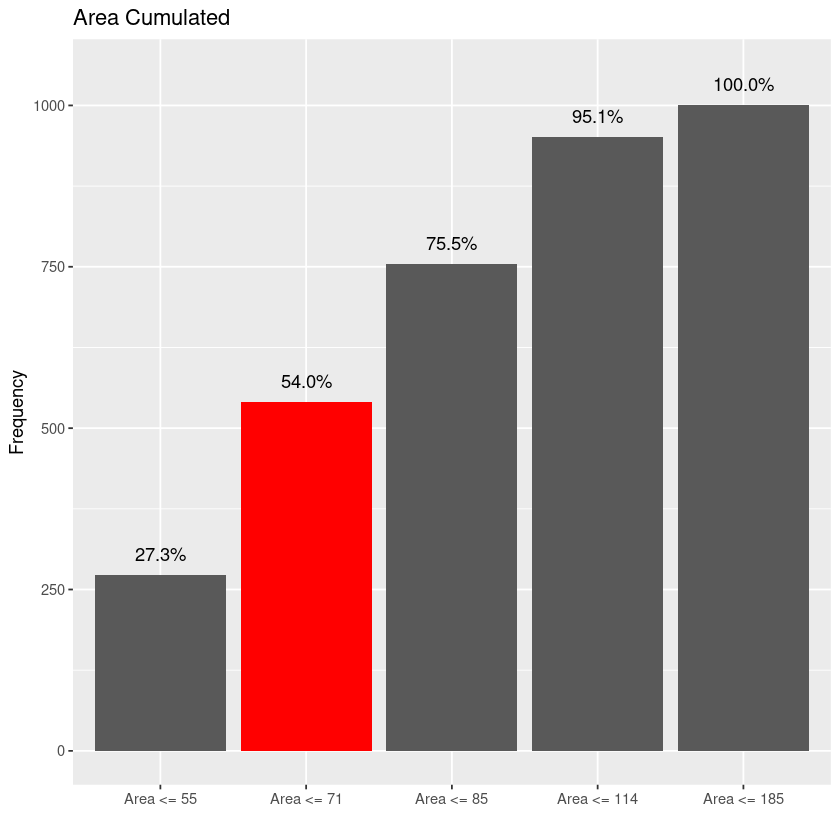

In [ ]:
area <- rent$Area
area_stats <- c(round(min(area))-1, round(quantile(area, 0.25)), round(mean(area)), round(quantile(area, 0.75)), round(quantile(area, 0.95)), round(max(area)))

cat_area <- cut(area, area_stats)

# haeufigkeiten der kategorien
table_area_cat <- table(cat_area)

# cusum 
cumsum_cat_area <- cumsum(table_area_cat)
names(cumsum_cat_area) <- paste("Area <=", area_stats[-1])
df_cumsum_area <- data.frame(Cat = names(cumsum_cat_area), Freq = cumsum_cat_area)

# speicher in einem data frame fuer die visualisierung
df_area <- data.frame(table_area_cat)

# einige ausreisser nach oben
ggplot(rent) + geom_boxplot(aes(y = area)) + labs(title="Area", x ="", y = "Frequency")
# boxplot(wf)

# histogram
# ggplot(rent) + geom_histogram(aes(x = area)) 

# histogram der kategorien 
ggplot(df_area, aes(x=cat_area, y = Freq)) + geom_bar(stat = "identity", fill = c("grey35", "red", "red", "grey35", "grey35")) + geom_text(aes(label = Freq), vjust = -1 ) + labs(title="Area",
        x ="", y = "Frequency") + ylim(c(0, 320))

# kummulierte haeufigkeiten
df_cumsum_area %>% arrange(Freq) %>% mutate(name = factor(Cat, levels=names(cumsum_cat_area))) %>% ggplot(aes(x=name, y = Freq, label = scales::percent(Freq/1000))) + geom_bar(stat = "identity", fill = c("grey35", "red", "grey35", "grey35", "grey35")) + geom_text(vjust = -1) + labs(title="Area Cumulated", x ="", y = "Frequency") + ylim(c(0, 1050))

### Rooms

71.2% of the apartments have two or three rooms. The frequency decreases sharply towards the edges (Graph 1, top). Clearly above all the number of apartments with five or six apartments accounts for 3.1% of the total apartments. 82.4% of the apartments have three or fewer rooms (Graph 2, bottom).

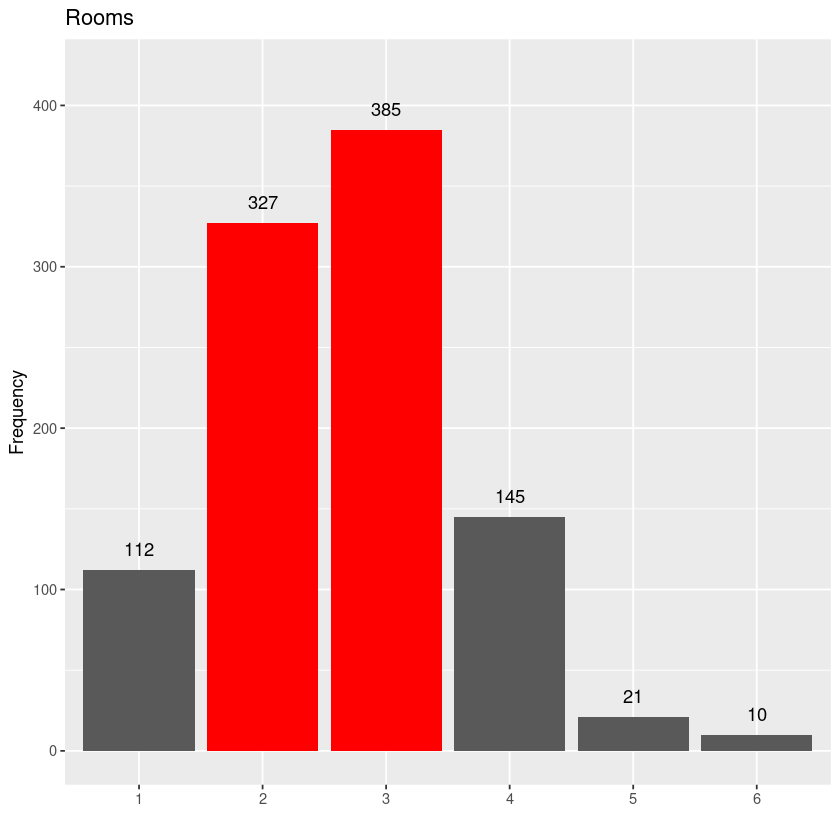

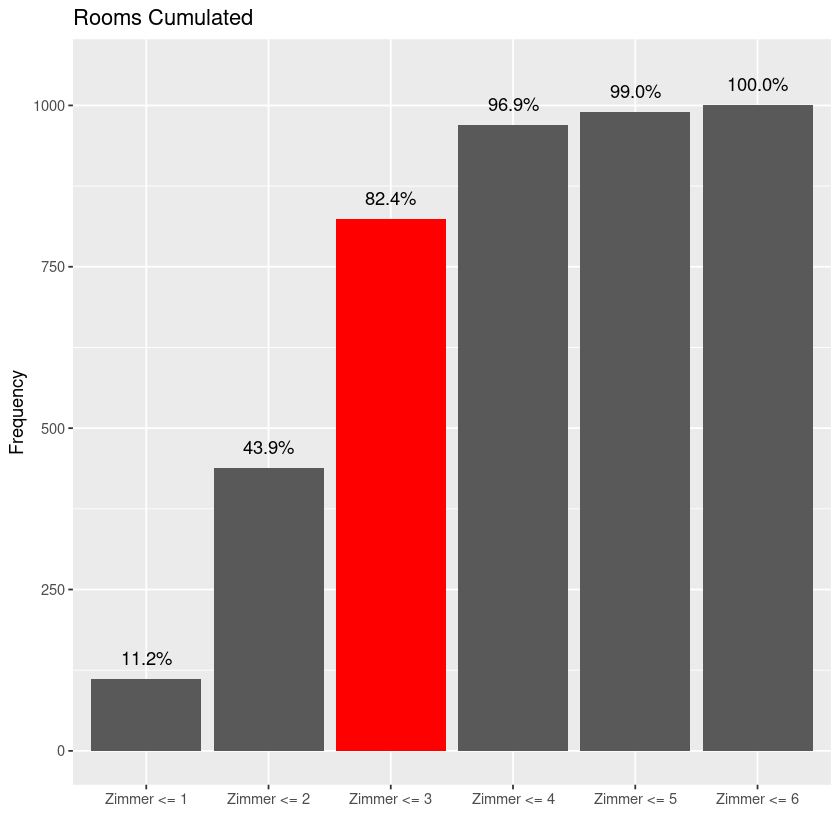

In [ ]:
rooms <- rent$Rooms

# haeufigkeiten der kategorien
table_rooms <- table(rooms)

# cusum 
cumsum_rooms <- cumsum(table_rooms)
names(cumsum_rooms) <- paste("Zimmer <=", names(table_rooms))
df_cumsum_rooms <- data.frame(Cat = names(cumsum_rooms), Freq = cumsum_rooms)

# speicher in einem data frame fuer die visualisierung
df_rooms <- data.frame(table_rooms)

# histogram der kategorien 
ggplot(df_rooms, aes(x=rooms, y = Freq)) + geom_bar(stat = "identity", fill = c("grey35", "red", "red","grey35", "grey35", "grey35")) + geom_text(aes(label = Freq), vjust = -1 ) + labs(title="Rooms",
        x ="", y = "Frequency") + ylim(c(0, 420))

# kummulierte haeufigkeiten
df_cumsum_rooms %>% arrange(Freq) %>% mutate(name = factor(Cat, levels=names(cumsum_rooms))) %>% ggplot(aes(x=name, y = Freq, label = scales::percent(Freq/1000))) + geom_bar(stat = "identity",fill = c("grey35", "grey35", "red","grey35", "grey35", "grey35")) + geom_text(vjust = -1) + labs(title="Rooms Cumulated", x ="", y = "Frequency") + ylim(c(0, 1050))

### Age

In the following, the notation "80+" is introduced for all apartments older than 80 years. There was a significant slump (40) in residential construction, especially in the period between the First and Second World Wars. This was followed by a sharp increase in the post-war years into the 1980s, when housing construction stabilized. 76.1% of all dwellings were built after World War II.

In [ ]:
names(rent)

[1] "Rent"          "Area"          "Rooms"         "Age_Grouped"  
 [5] "Resid_Complex" "No_WWSupply"   "No_Centr_Heat" "No_Tiled_Bath"
 [9] "Elev_Bath"     "Elev_Kitchen"

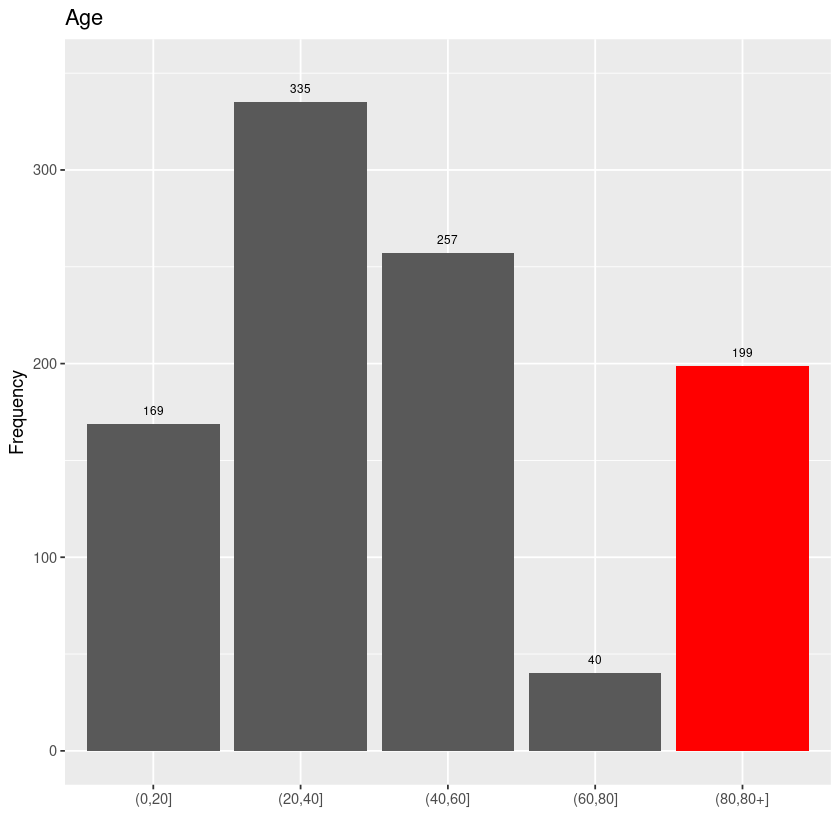

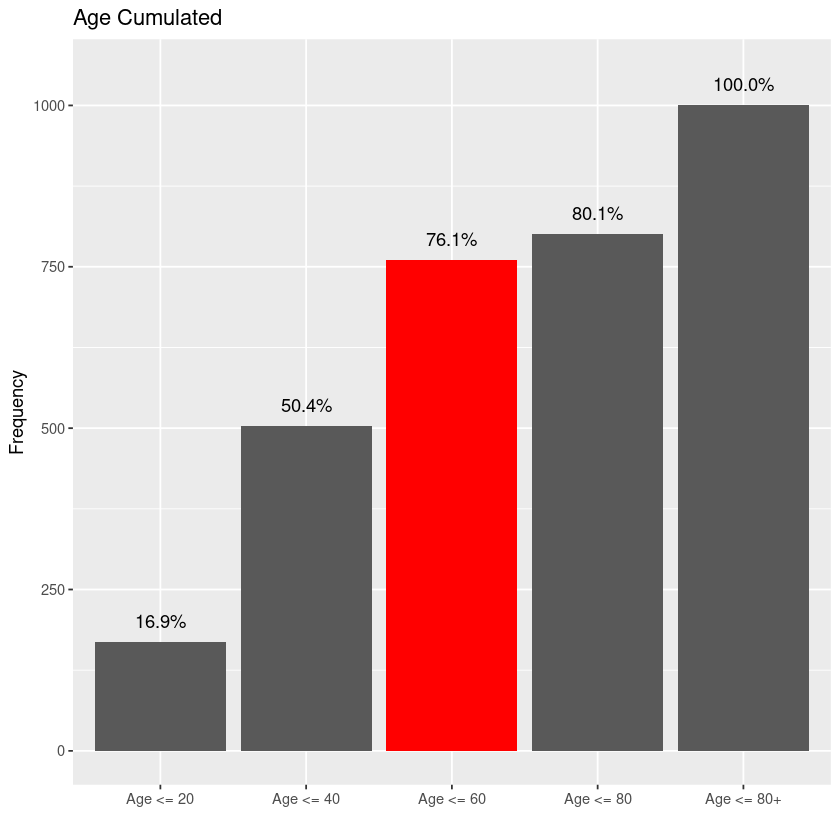

In [ ]:
age <- rent$Age_Grouped
table_age <- table(age)
names(table_age) <- c(names(table(age))[1:4], "(80,80+]")

# cusum 
cumsum_age <- cumsum(table_age)
names(cumsum_age) <- paste("Age <=", c(20, 40, 60, 80, "80+"))
df_cumsum_age <- data.frame(Cat = names(cumsum_age), Freq = cumsum_age)

# speicher in einem data frame fuer die visualisierung
df_age <- data.frame(table_age)

# histogram der kategorien 
ggplot(df_age, aes(x= Var1, y = Freq)) + geom_bar(stat = "identity", fill = c("grey35", "grey35", "grey35","grey35", "red")) + geom_text(aes(label = Freq), vjust = -1,size = 2.5 ) + labs(title="Age", x ="", y = "Frequency") + ylim(c(0, 350)) 

# Cum Freq
df_cumsum_age %>% arrange(Freq) %>% mutate(name = factor(Cat, levels=names(cumsum_age))) %>% ggplot(aes(x=name, y = Freq, label = scales::percent(Freq/1000))) + geom_bar(stat = "identity", fill = c("grey35", "grey35", "red","grey35", "grey35")) + geom_text(vjust = -1) + labs(title="Age Cumulated", x ="", y = "Frequency") + ylim(c(0, 1050))

### Categorical Variables

The data set also contains categorical variables, the frequencies of which are shown in the following graphics. For all of the following variables, there are large differences in frequency.

In [ ]:
names(rent)

[1] "Rent"          "Area"          "Rooms"         "Age_Grouped"  
 [5] "Resid_Complex" "No_WWSupply"   "No_Centr_Heat" "No_Tiled_Bath"
 [9] "Elev_Bath"     "Elev_Kitchen"

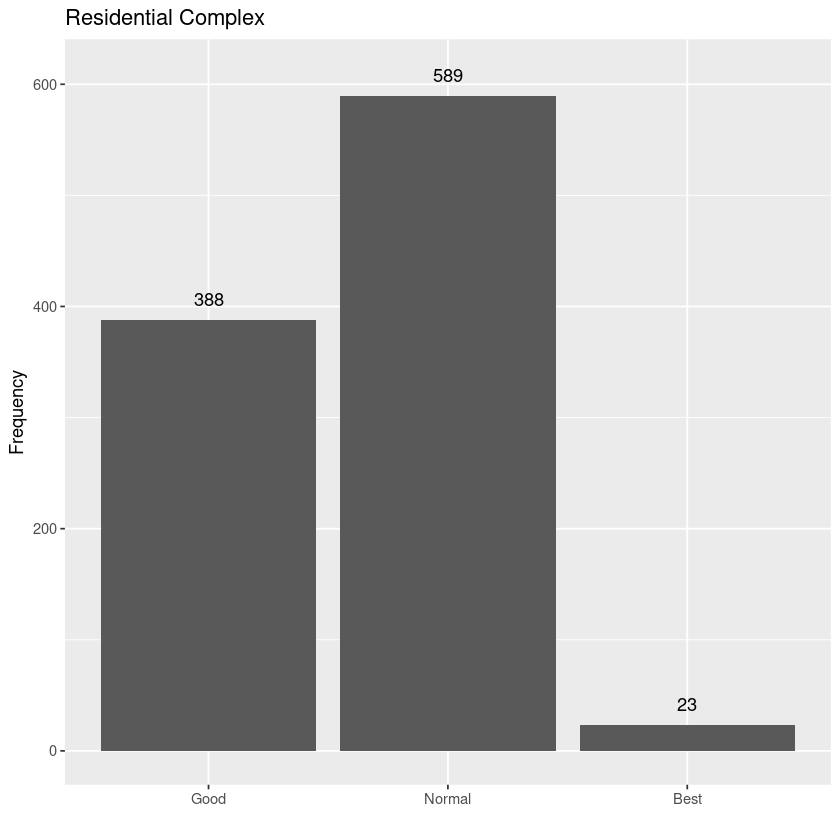

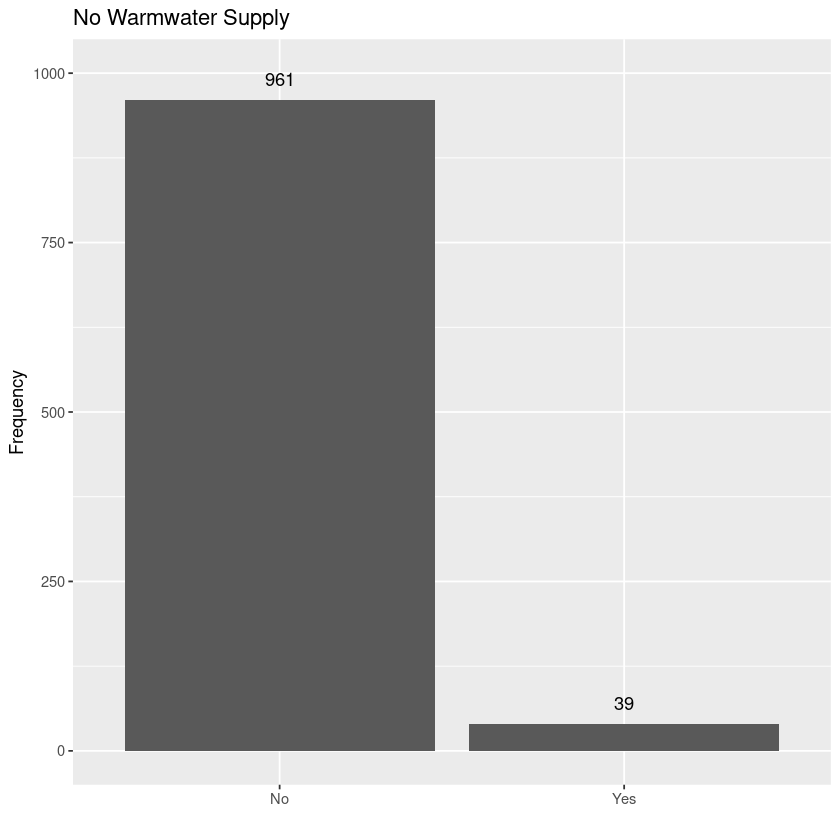

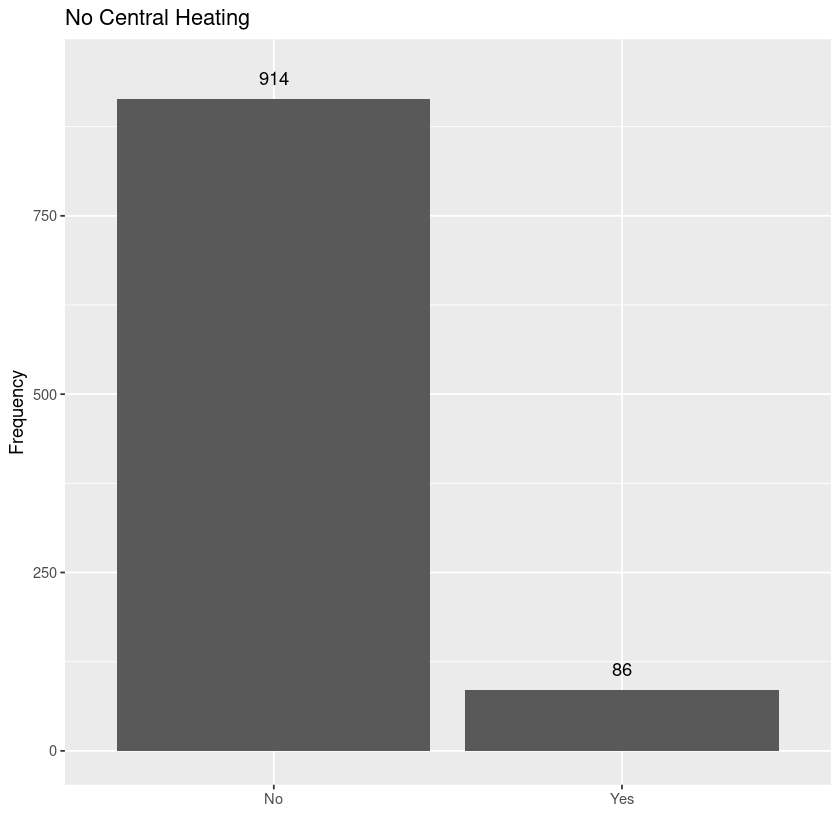

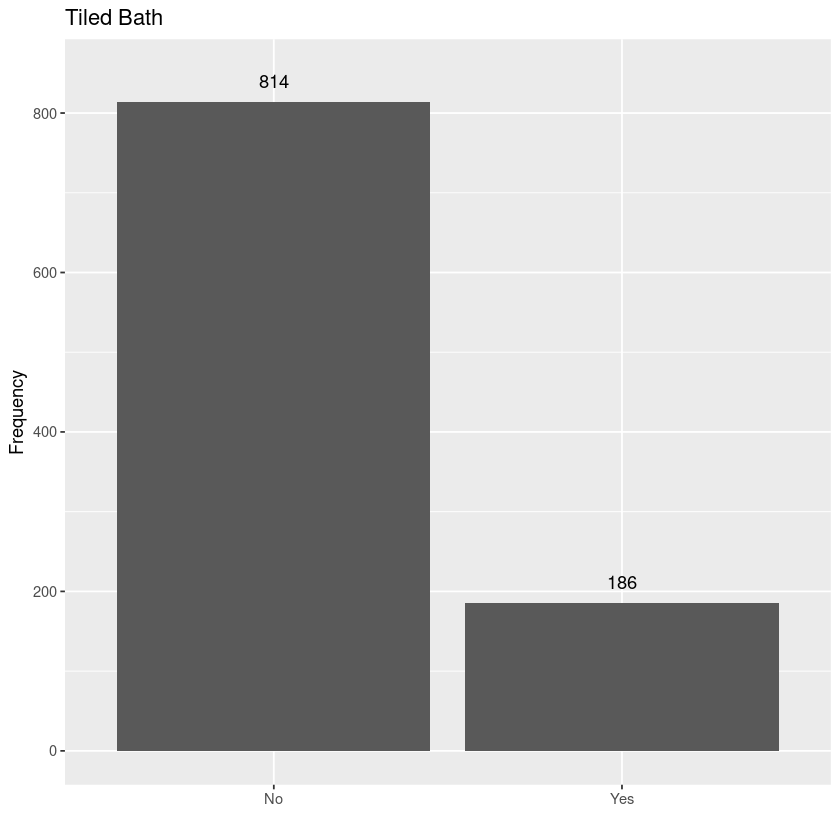

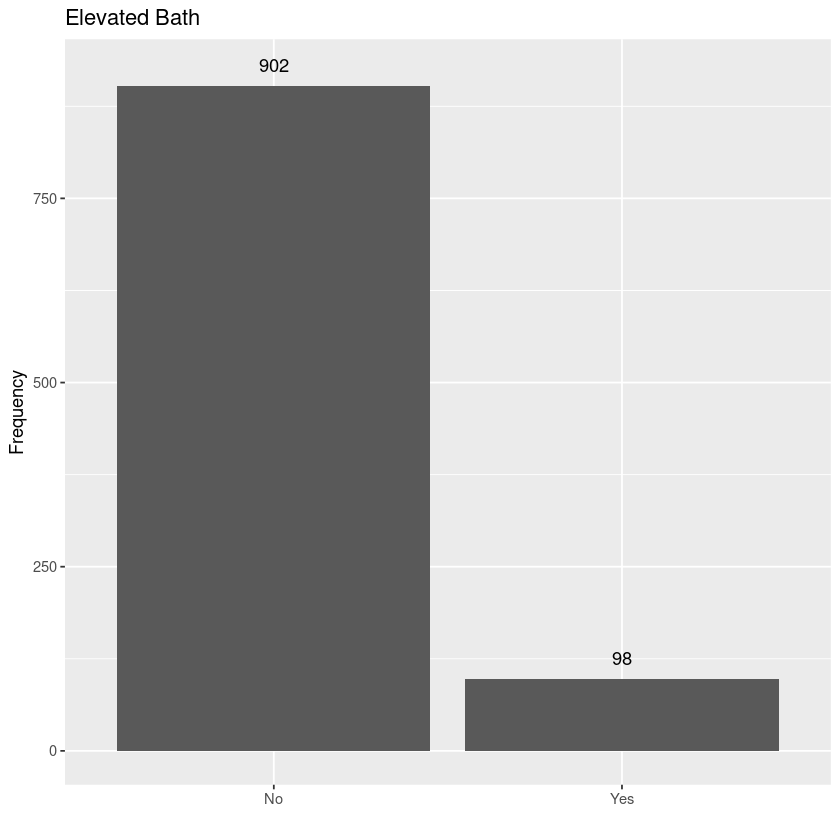

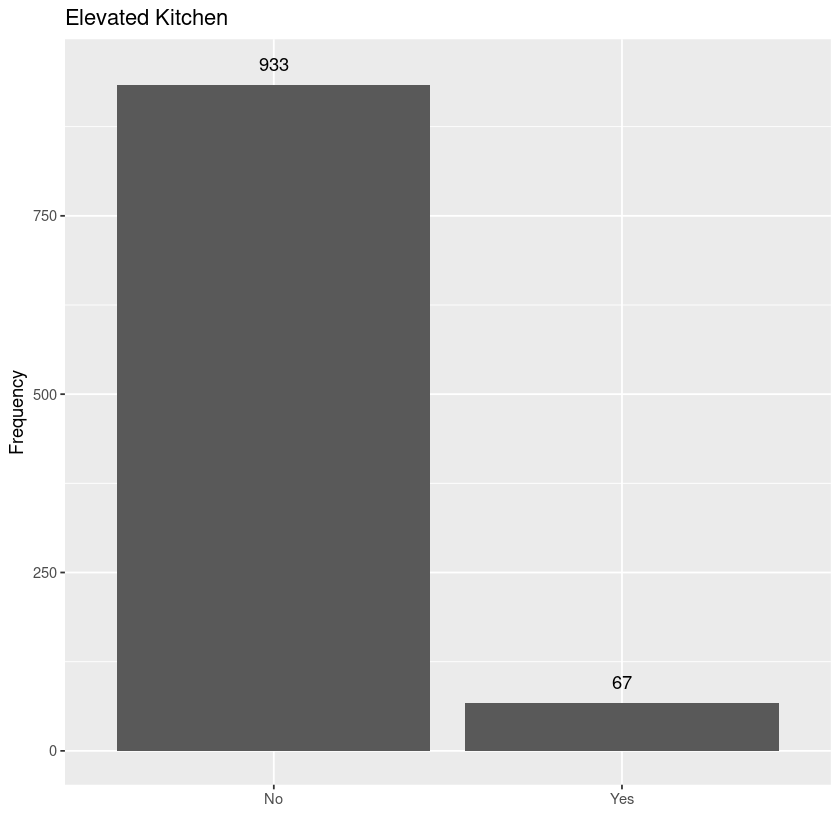

In [ ]:
table_rq <- table(rent$Resid_Complex)
table_no_wws <- table(rent$No_WWSupply)
table_no_centr_heat <- table(rent$No_Centr_Heat)
table_no_tiled_bath <- table(rent$No_Tiled_Bath)
table_elev_bath <- table(rent$Elev_Bath)
table_elev_kitch <- table(rent$Elev_Kitchen)

ggplot(data.frame(table_rq), aes(x = Var1, y = Freq)) + geom_bar(stat = "identity") + geom_text(label = table_rq, vjust = -1) + labs(title="Residential Complex", x ="", y = "Frequency") + ylim(c(0,610))

ggplot(data.frame(table_no_wws), aes(x = Var1, y = Freq)) + geom_bar(stat = "identity") + geom_text(label = table_no_wws, vjust = -1) + labs(title="No Warmwater Supply", x ="", y = "Frequency")+ scale_x_discrete(labels = c("No", "Yes")) + ylim(c(0,1000))

ggplot(data.frame(table_no_centr_heat), aes(x = Var1, y = Freq)) + geom_bar(stat = "identity") + geom_text(label = table_no_centr_heat, vjust = -1) + labs(title="No Central Heating", x =" ", y = "Frequency") + scale_x_discrete(labels = c("No", "Yes")) + ylim(c(0,950))

ggplot(data.frame(table_no_tiled_bath), aes(x = Var1, y = Freq)) + geom_bar(stat = "identity") + geom_text(label = table_no_tiled_bath, vjust = -1) + labs(title="Tiled Bath", x ="", y = "Frequency") + scale_x_discrete(labels = c("No", "Yes")) + ylim(c(0,850))

ggplot(data.frame(table_elev_bath), aes(x = Var1, y = Freq)) + geom_bar(stat = "identity") + geom_text(label = table_elev_bath, vjust = -1) + labs(title="Elevated Bath", x ="", y = "Frequency") + scale_x_discrete(labels = c("No", "Yes")) + ylim(c(0,920))

ggplot(data.frame(table_elev_kitch), aes(x = Var1, y = Freq)) + geom_bar(stat = "identity") + geom_text(label = table_elev_kitch, vjust = -1) + labs(title="Elevated Kitchen", x ="", y = "Frequency") + scale_x_discrete(labels = c("No", "Yes")) + ylim(c(0, 950))

## Bivariate Analysis

The graphs below show the correlations of the variables. The graph on top contains all and the graph on the bottom only the significant correlations. We can observe: 1) Rent is significantly correlated with almost all other variables. 2) Elevated Kitchen is not significantly correlated with any other variable. 3) Area and Rooms have the strongest positive correlation and Rent and Area are the second strongest.

In [ ]:
names(rent)

[1] "Rent"          "Area"          "Rooms"         "Age_Grouped"  
 [5] "Resid_Complex" "No_WWSupply"   "No_Centr_Heat" "No_Tiled_Bath"
 [9] "Elev_Bath"     "Elev_Kitchen"

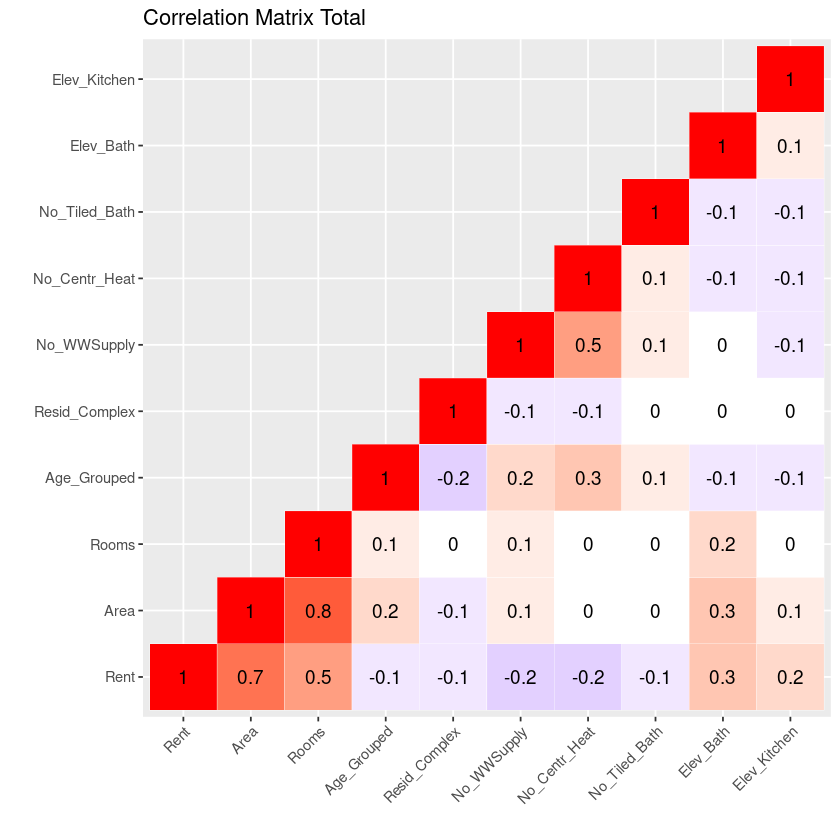

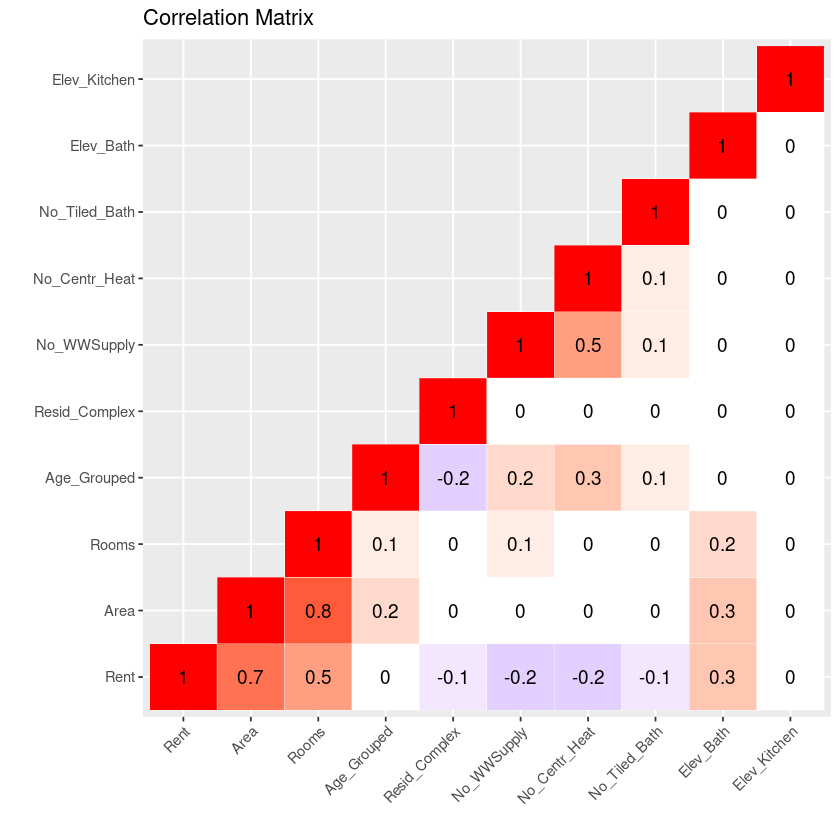

In [ ]:
t_cor <- function(x, n) x * sqrt(n-2) / sqrt(1 - x^2)
t_test <- function(x, alpha = 0.05) {
        if(1-pt(abs(x),999) < alpha / 2){
			return(TRUE)
        } else {
			return(FALSE)
		}
}

cor_rent <- cor(cbind(rent$Rent, rent$Area, rent$Rooms, as.numeric(rent$Age_Grouped), 
                  as.numeric(rent$Resid_Complex), rent$No_WWSupply, rent$No_Centr_Heat, rent$No_Tiled_Bath, rent$Elev_Bath, rent$Elev_Kitchen))

cor_cp <- cor_rent
cor_cp[row(cor_cp) < col(cor_cp)] <- NA         
colnames(cor_cp) <- names(rent)
rownames(cor_cp) <- names(rent)
diag(cor_cp) <- 1

# val <- as.numeric(cor_rent)
val <- melt(cor_cp, na.rm = TRUE)
val$value <- round(val$value, 1) 

ggplot(val, aes(Var1, Var2, fill = value)) + geom_tile(colour = "white") + labs(title="Correlation Matrix Total", x ="", y = "") + scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limit = c(-1,1), space = "Lab",name="Pearson\nCorrelation") + scale_x_discrete(guide = guide_axis(angle = 45)) + geom_text(aes(Var1, Var2, label = value), color = "black", size = 4) + theme(legend.position = "none")

# signifikant
cor_matr_t_val <- apply(cor_rent, 2, t_cor, n = nrow(rent))
diag(cor_matr_t_val) <- 0
res <- matrix(0, ncol = ncol(cor_rent), nrow = nrow(cor_rent))

for(i in 1:(nrow(cor_matr_t_val)-1)){
	for(j in 1:nrow(cor_matr_t_val)){
		if(t_test(cor_matr_t_val[i,j], alpha = 0.01)){
			res[i,j] <- cor_rent[i,j]
		}
	}
}

res[row(res) < col(res)] <- NA         
colnames(res) <- names(rent)
rownames(res) <- names(rent)
diag(res) <- 1

# val <- as.numeric(cor_rent)
val <- melt(res, na.rm = TRUE)
val$value <- round(val$value, 1) 

ggplot(val, aes(Var1, Var2, fill = value)) + geom_tile(colour = "white") + labs(title="Correlation Matrix", x ="", y = "") + scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limit = c(-1,1), space = "Lab",name="Pearson\nCorrelation") + scale_x_discrete(guide = guide_axis(angle = 45)) + geom_text(aes(Var1, Var2, label = value), color = "black", size = 4) + theme(legend.position = "none")

The connection between the net rent and selected variables is shown below. With increasing living space and increasing number of rooms, the net rent increases. A linear connection with increasing scatter can be observed here. We can observe a non-linear relationship between age and net rent. Specifically, the net rent increases for the youngest (0 to 20 years) and the oldest (80+).

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



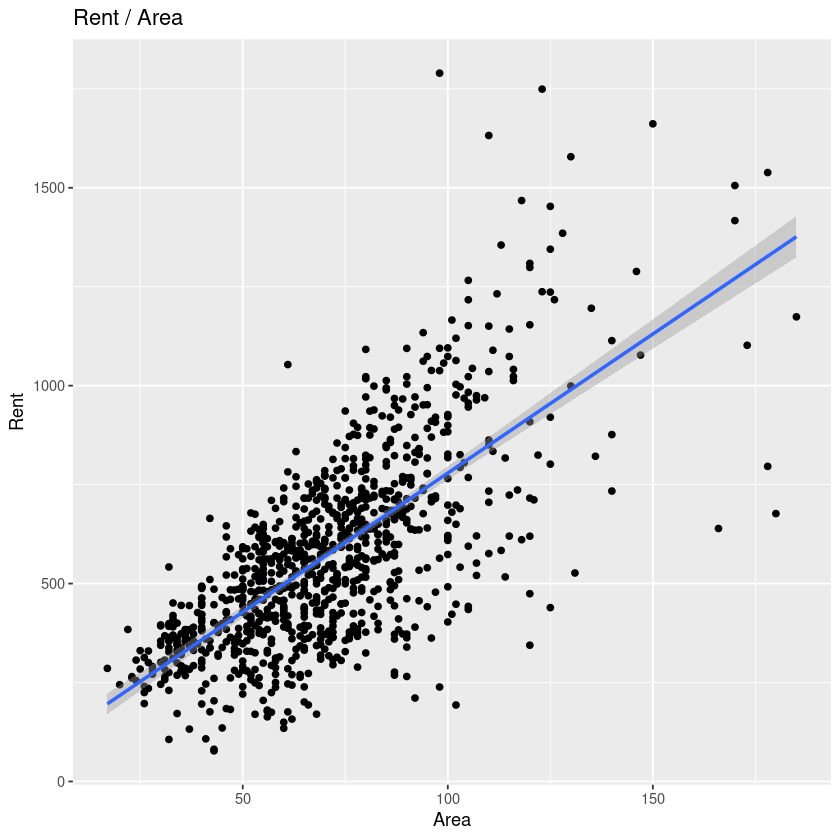

`geom_smooth()` using formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.98”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.02”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  5.449e-15”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 0.98”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 2.02”
Warning message in predLoess(object$y, object$x,

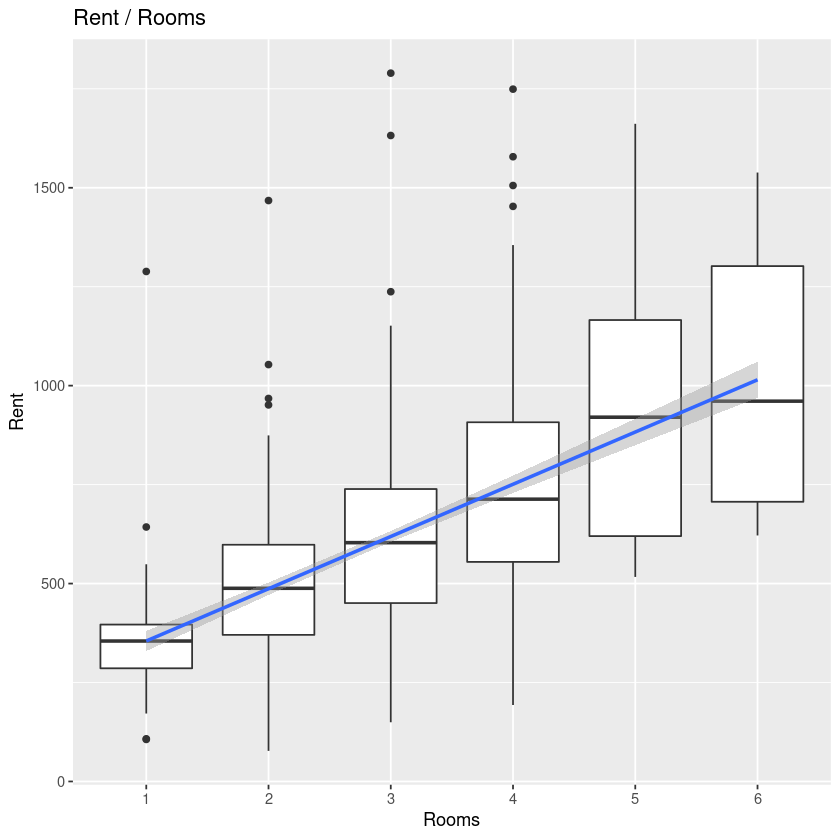

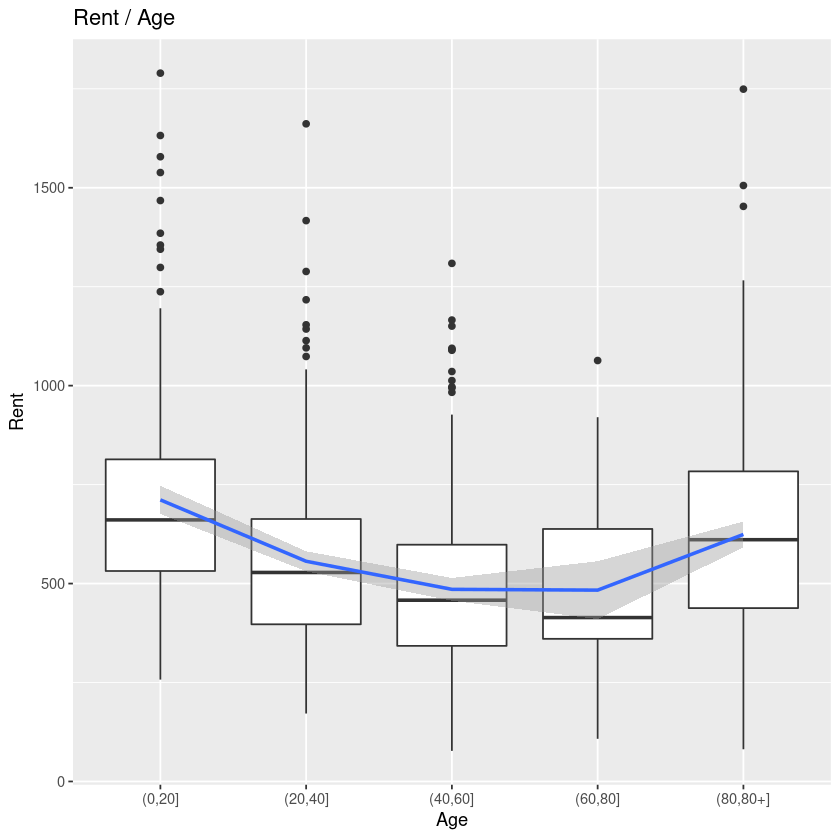

In [ ]:
ggplot(rent, aes(x = Area, y = Rent)) + geom_point() + geom_smooth(method = "lm") + labs(title="Rent / Area", x ="Area", y = "Rent")

ggplot(rent, aes(x = as.factor(Rooms), y = Rent)) + geom_boxplot() + geom_smooth(method = "lm", se=TRUE, aes(group=1)) + labs(title="Rent / Rooms", x ="Rooms", y = "Rent")

ggplot(rent, aes(x = Age_Grouped, y = Rent)) + geom_boxplot() + labs(title="Rent / Age", x ="Age", y = "Rent") + geom_smooth(method = "loess", se=TRUE, aes(group=1))+ scale_x_discrete(labels = names(table_age))

In the following, the net rent for the remaining variables is shown for the corresponding characteristics. In all cases, there are clear differences between the categories.

In [ ]:
names(rent)

[1] "Rent"          "Area"          "Rooms"         "Age_Grouped"  
 [5] "Resid_Complex" "No_WWSupply"   "No_Centr_Heat" "No_Tiled_Bath"
 [9] "Elev_Bath"     "Elev_Kitchen"

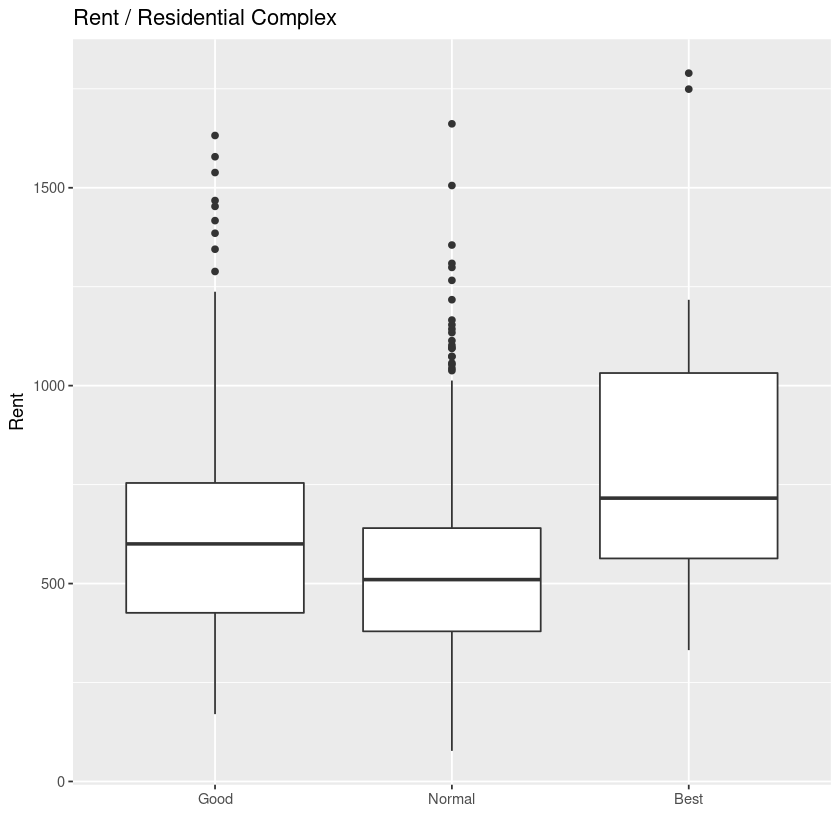

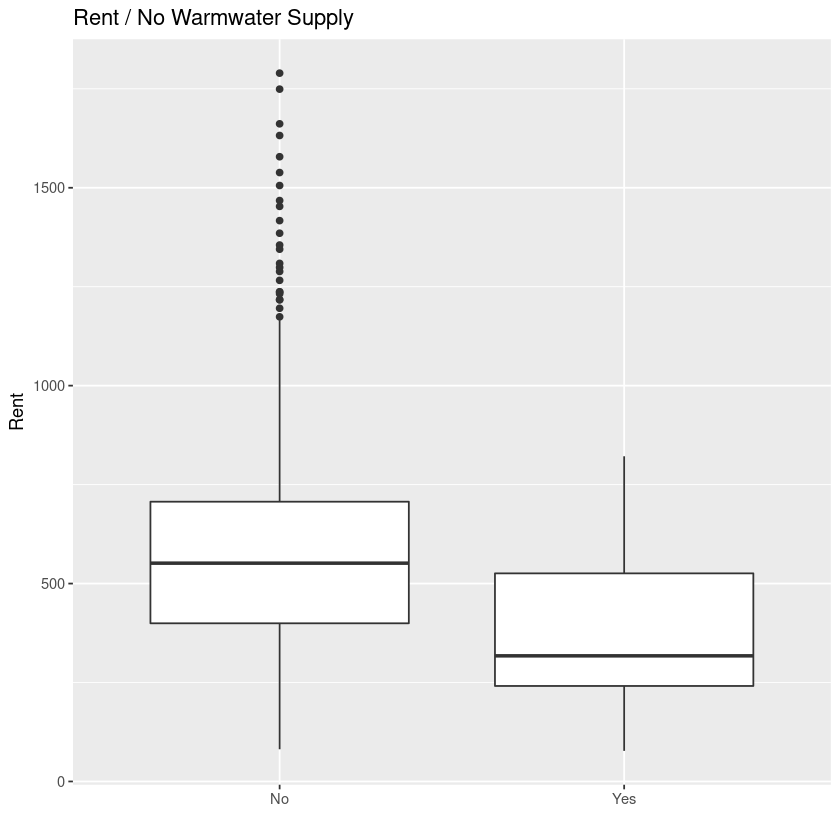

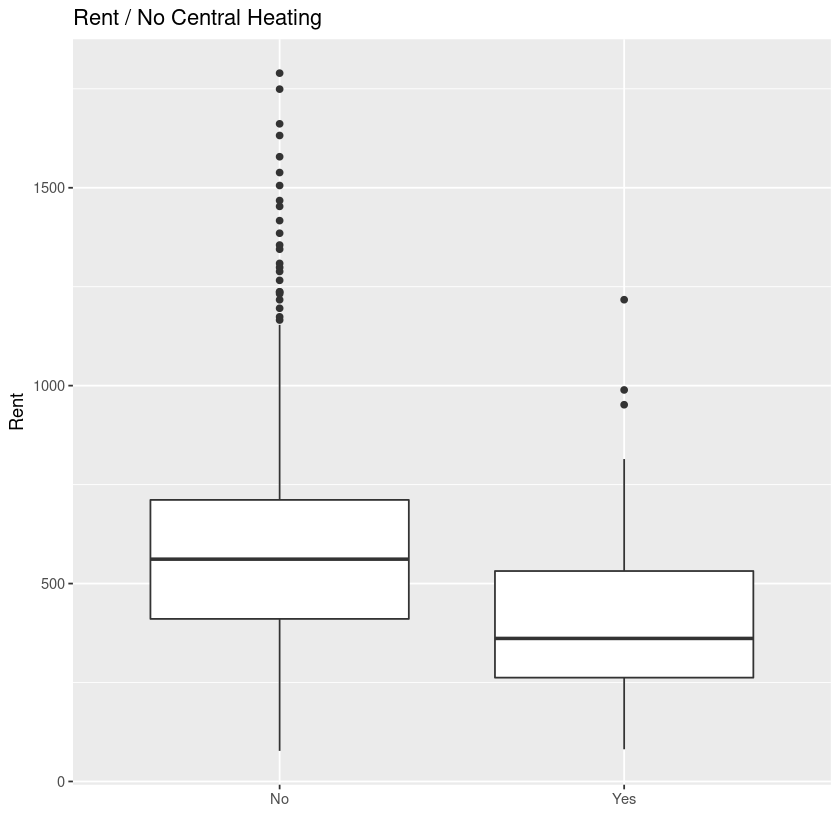

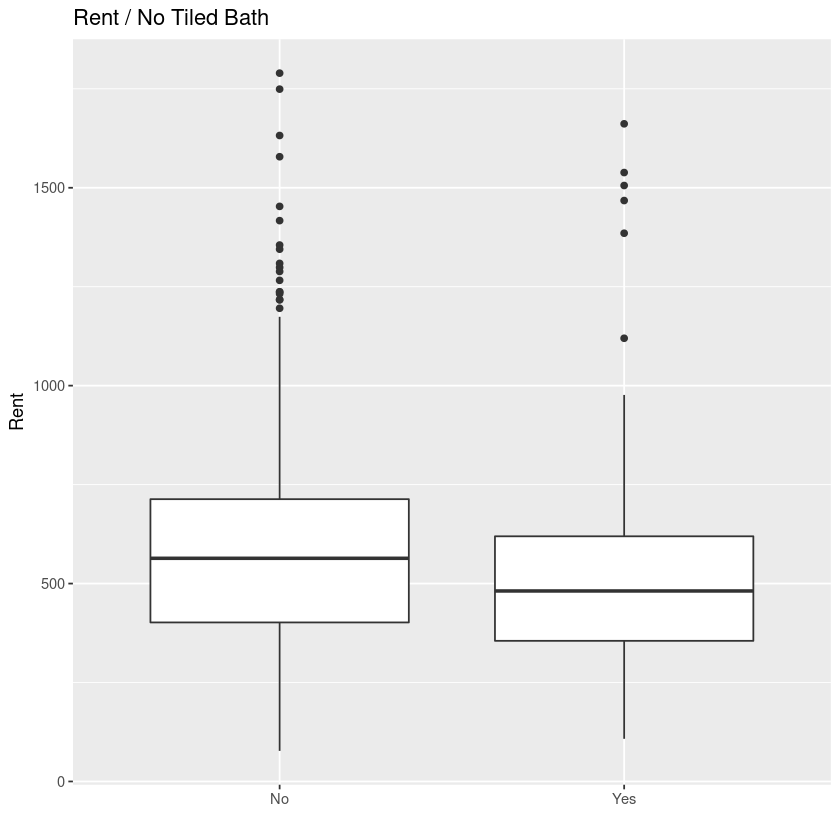

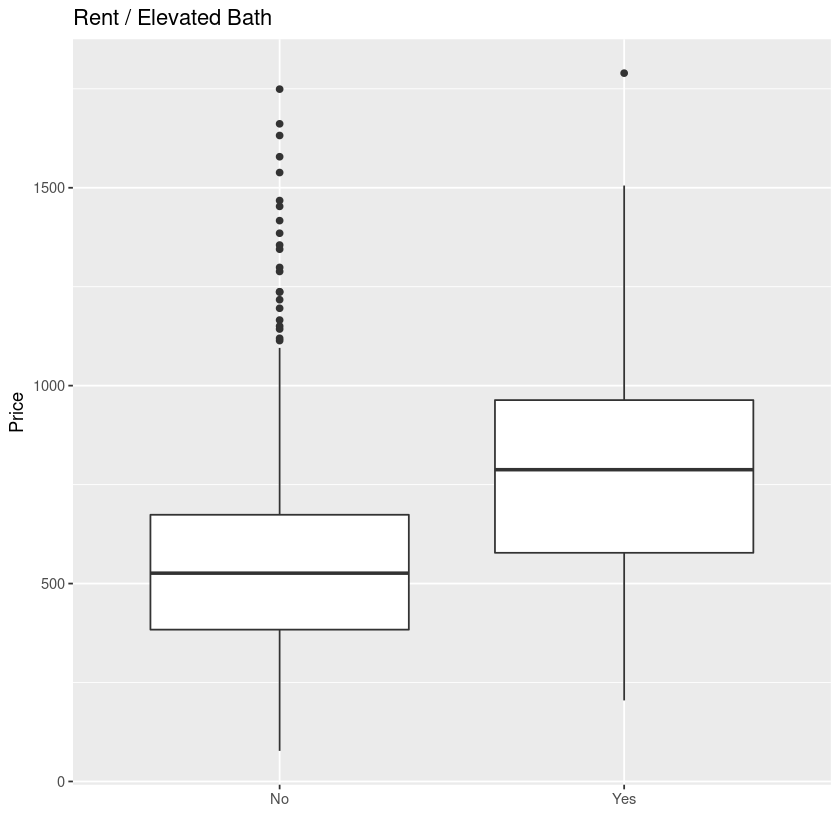

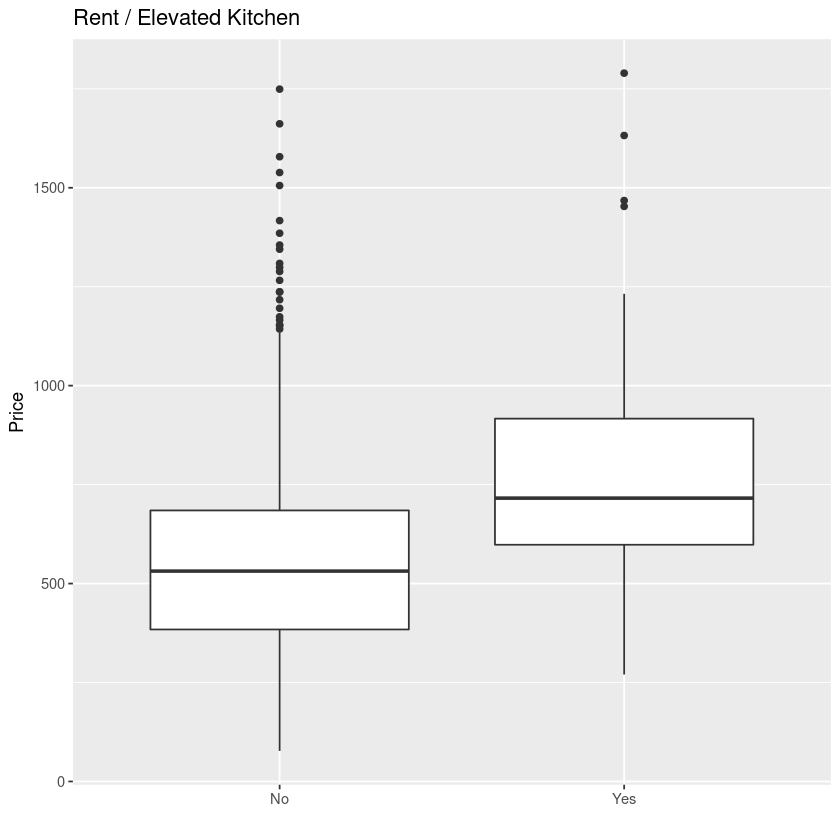

In [ ]:
ggplot(rent, aes(x = Resid_Complex, y = Rent)) + geom_boxplot() + labs(title="Rent / Residential Complex", x ="", y = "Rent")

# warmwasser
ggplot(rent, aes(x = as.factor(No_WWSupply), y = Rent)) + geom_boxplot() + labs(title="Rent / No Warmwater Supply", x ="", y = "Rent") + scale_x_discrete(labels = c("No", "Yes"))

# zentralheizung
ggplot(rent, aes(x = as.factor(No_Centr_Heat), y = Rent)) + geom_boxplot() + labs(title="Rent / No Central Heating", x ="", y = "Rent") + scale_x_discrete(labels = c("No", "Yes"))

# gekacheltes badezimmer
ggplot(rent, aes(x = as.factor(No_Tiled_Bath), y = Rent)) + geom_boxplot() + labs(title="Rent / No Tiled Bath", x ="", y = "Rent") + scale_x_discrete(labels = c("No", "Yes"))

# badezimmer extraausstattung
ggplot(rent, aes(x = as.factor(Elev_Bath), y = Rent)) + geom_boxplot() + labs(title="Rent / Elevated Bath", x ="", y = "Price") + scale_x_discrete(labels = c("No", "Yes"))
#summary(aov(nm ~ badextra))
#summary(lm(nm ~ badextra))

# gehobene kueche
ggplot(rent, aes(x = as.factor(Elev_Kitchen), y = Rent)) + geom_boxplot() + labs(title="Rent / Elevated Kitchen", x ="", y = "Price") + scale_x_discrete(labels = c("No", "Yes"))
#summary(aov(nm ~ kueche))
#summary(lm(nm ~ kueche))

## Trivariate Analysen
In the following, connections between the net rental price and two other variables are shown. This representation enables a differentiated consideration of effects that only occur between two variables at the same time. Striking differences could be determined especially for the variables living space, age grouped and residential complex.

### Living Space + 

We suspect that the living space is the main driver for the rental price and therefore consider all models where the net rent is represented by the living space and another variable. The following graphics each show the regression line for the living area depending on the second variable. We are particularly interested in different slopes as these serve as an indicator for interaction effects between two variables. The following graphs show the corresponding results. We observe that the net value for living area and:

* Apartments with six rooms (a)
* Apartments up to 20 years (b)
* in the best location (c)
* with central heating and (d)
* with upscale cuisine (e)

differs significantly from others.


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



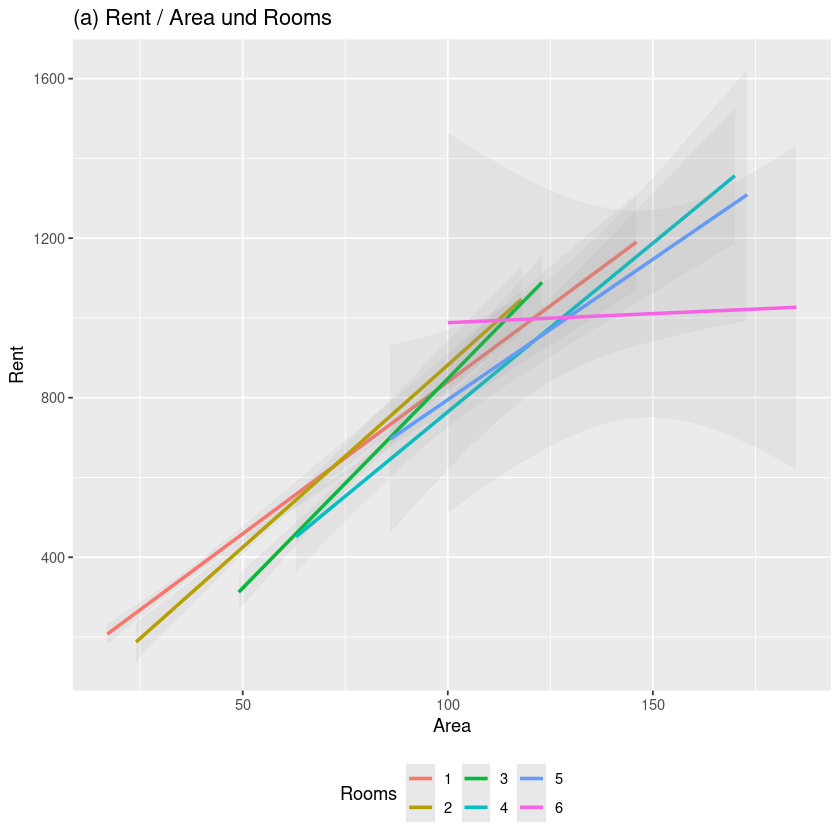

`geom_smooth()` using formula 'y ~ x'



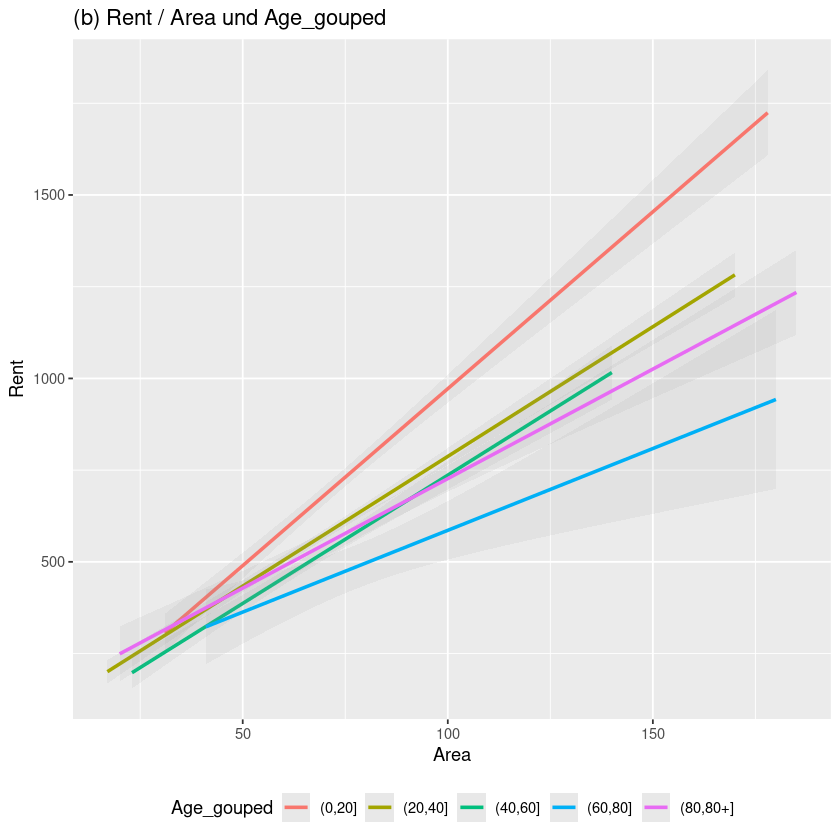

`geom_smooth()` using formula 'y ~ x'



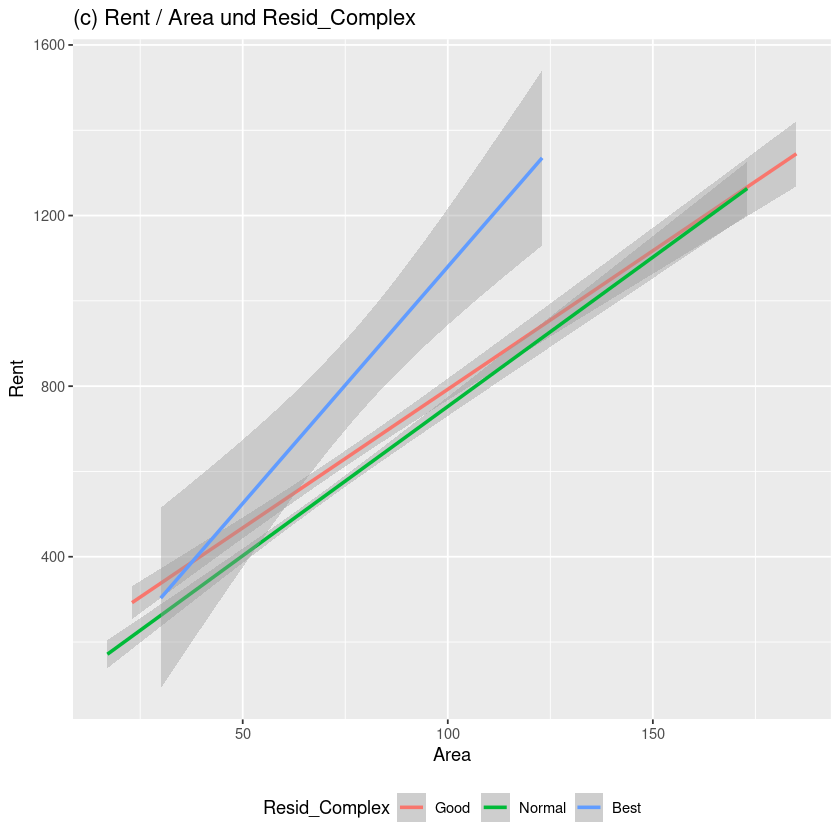

`geom_smooth()` using formula 'y ~ x'



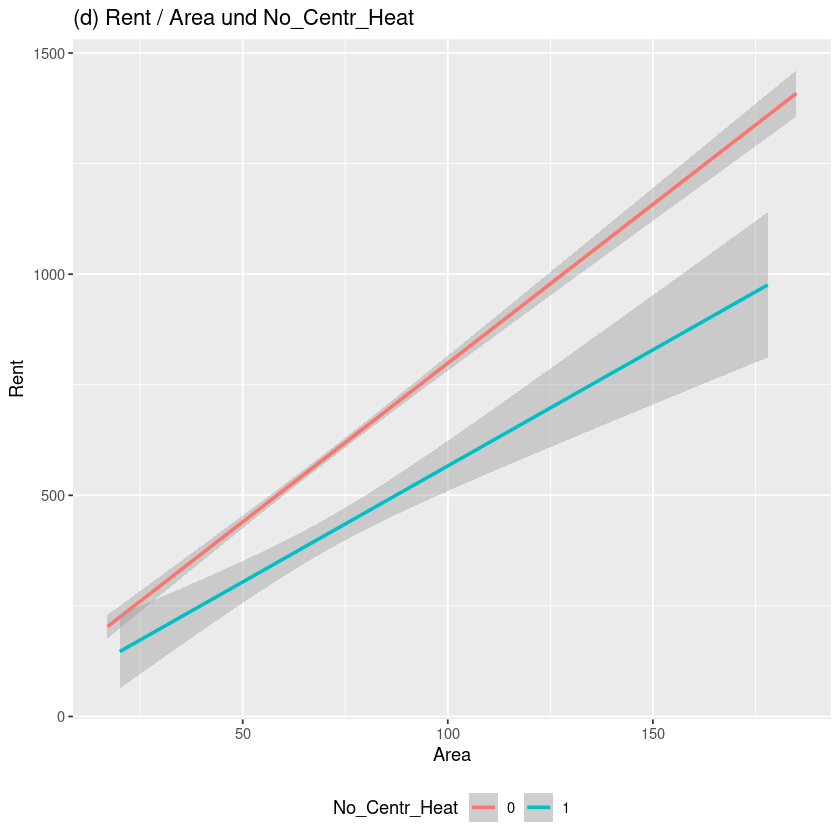

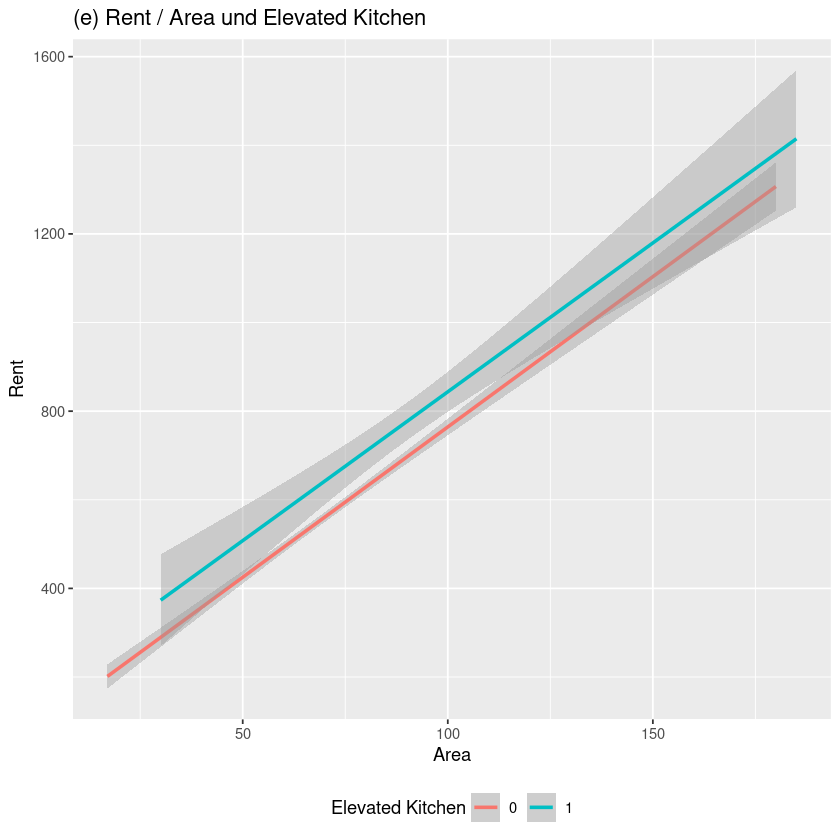

In [ ]:
ggplot(rent, aes(x = Area, y = Rent, color= as.factor(Rooms))) + geom_smooth(method = "lm", alpha = 0.1 ) + labs(title="(a) Rent / Area und Rooms", x ="Area", y = "Rent", color = "Rooms") + theme(legend.position = "bottom")

ggplot(rent, aes(x = Area, y = Rent, color = Age_Grouped)) + geom_smooth(method = "lm", alpha = 0.1) + labs(title="(b) Rent / Area und Age_gouped", x ="Area", y = "Rent", color = "Age_gouped") + theme(legend.position = "bottom")

ggplot(rent, aes(x = Area, y = Rent, color = Resid_Complex)) +  geom_smooth(method = "lm") + labs(title="(c) Rent / Area und Resid_Complex", x ="Area", y = "Rent", color = "Resid_Complex") + theme(legend.position = "bottom")

ggplot(rent, aes(x = Area, y = Rent, color = as.factor(No_Centr_Heat))) + geom_smooth(method = "lm") + labs(title="(d) Rent / Area und No_Centr_Heat", x ="Area", y = "Rent", color = "No_Centr_Heat") + theme(legend.position = "bottom")

ggplot(rent, aes(x = Area, y = Rent, color = as.factor(Elev_Bath))) + geom_smooth(method = "lm") + labs(title="(e) Rent / Area und Elevated Kitchen", x ="Area", y = "Rent", color = "Elevated Kitchen") + theme(legend.position = "bottom")

### Age + 
The following two graphics show the net rental price for the different age groups depending on the number of rooms (a) and fine dining (b). For the number of rooms we can see a clear difference between six room apartments up to 20 years old and other six room apartments. In the case of apartments with a sophisticated kitchen, it is noticeable that the net rental price is constant across the age categories in comparison to apartments without a sophisticated kitchen. In this case, age has less of an impact on the rental price.

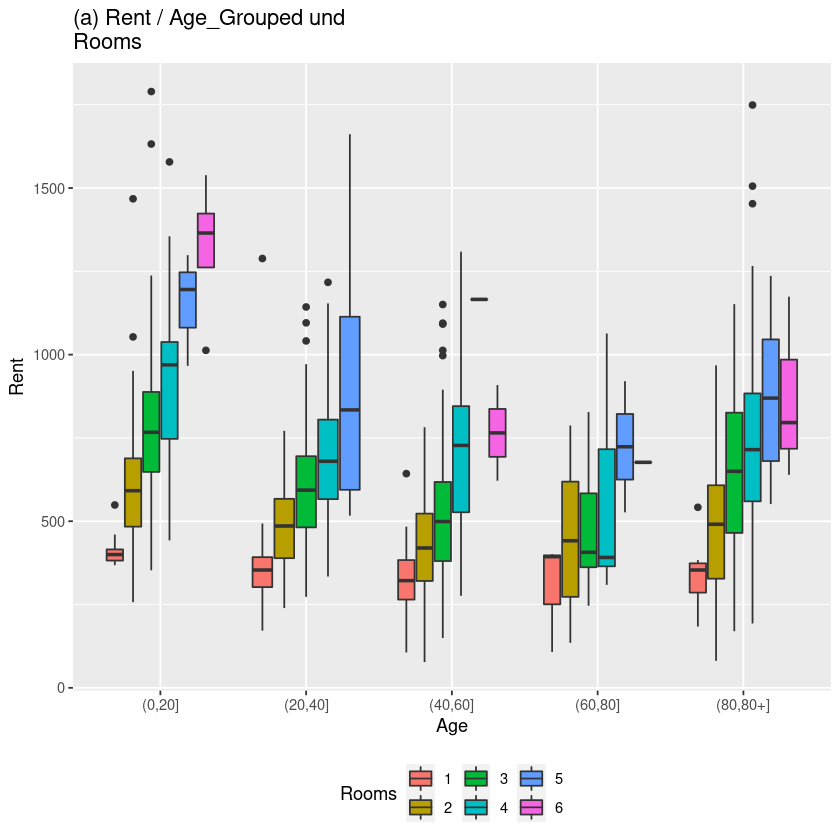

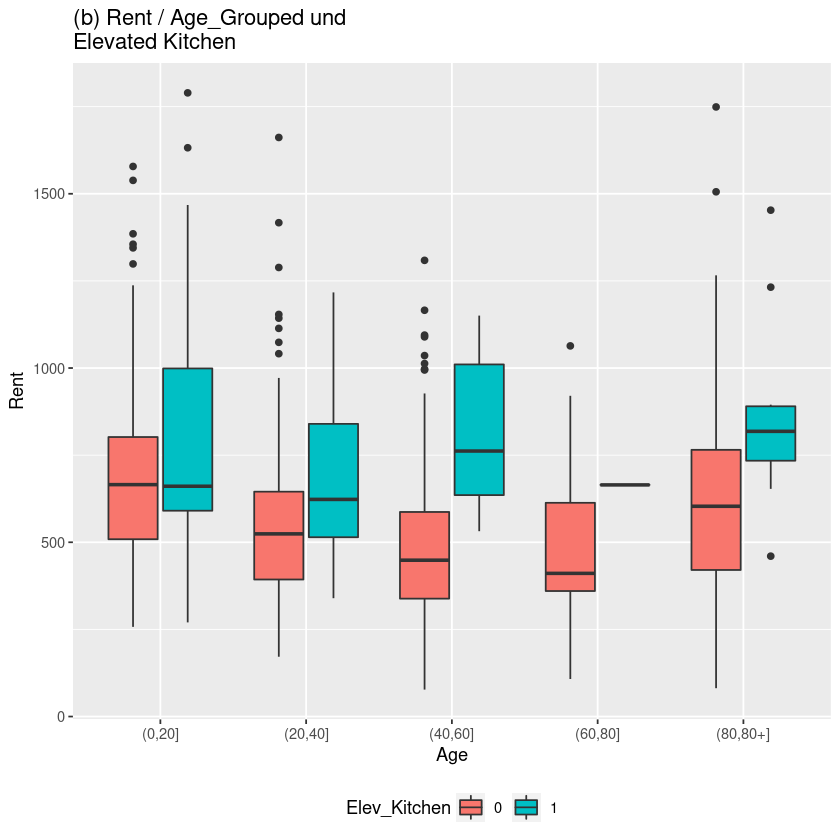

In [ ]:
ggplot(rent, aes(y = Rent, x = Age_Grouped, fill = as.factor(Rooms))) + geom_boxplot() + labs(title="(a) Rent / Age_Grouped und 
Rooms", x ="Age", y = "Rent", fill = "Rooms") + theme(legend.position = "bottom")

ggplot(rent, aes(y = Rent, x = Age_Grouped, fill = as.factor(Elev_Kitchen))) + geom_boxplot() + labs(title="(b) Rent / Age_Grouped und 
Elevated Kitchen", x ="Age", y = "Rent", fill = "Elev_Kitchen") + theme(legend.position = "bottom")


In [ ]:
names(rent)

[1] "Rent"          "Area"          "Rooms"         "Age_Grouped"  
 [5] "Resid_Complex" "No_WWSupply"   "No_Centr_Heat" "No_Tiled_Bath"
 [9] "Elev_Bath"     "Elev_Kitchen"

### Residential Complex
The following graphic shows the net rent per residential complex and extra bathroom equipment. As you can see, especially in the best residential complex, there is a significantly higher rental price for apartments with extra bathroom facilities than for others.

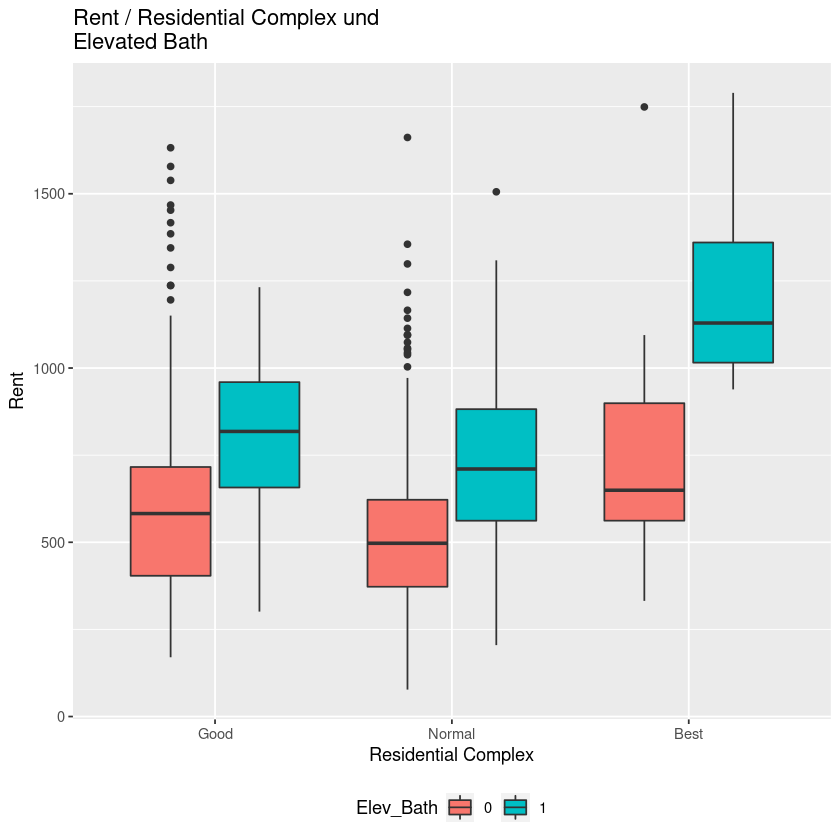

In [ ]:
ggplot(rent, aes(y = Rent, x = Resid_Complex, fill = as.factor(Elev_Bath))) + geom_boxplot() + labs(title="Rent / Residential Complex und 
Elevated Bath", x ="Residential Complex", y = "Rent", fill = "Elev_Bath") + theme(legend.position = "bottom")

# Modell Selection
Before the actual model is estimated, a decision tree should give us further information about possible connections.

## Decision Tree
Decision trees are a flexible means of computing class-specific averages. However, decision trees can be used for variable selection, because they create a hierarchy of the most important variables. The following graphic shows the decision tree for this data set.

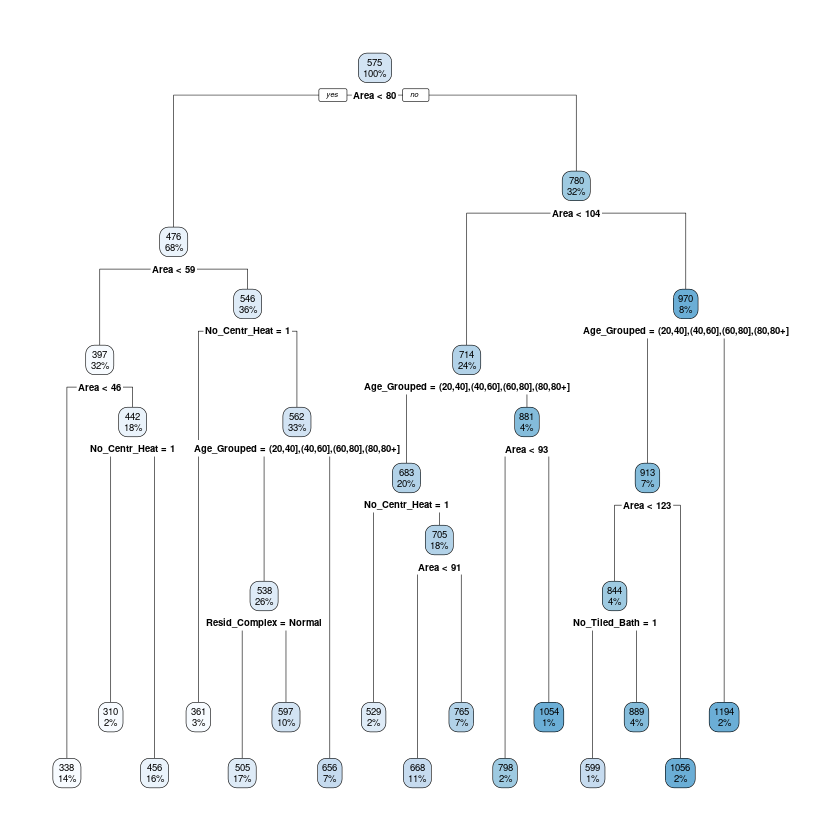

In [ ]:
tree <- rpart(Rent ~ ., data = rent, method = "anova", control=list(cp = 0.005))
rpart.plot(tree)

The graphic is to be understood as follows: The mean value of the net rent (575) is shown at the top level. This contains all, i.e. 100% of the observations. The greatest reduction in variance can be achieved by dividing the living space into apartments that are smaller or larger than 80 square meters (sqm). The average net rental price for apartments smaller than 80 sqm is 476 and for apartments larger than 80 sqm is 780. Further subdivisions follow this pattern.

Living space is the decision variable on the first two levels. For apartments under 80 square meters, we can observe that the variables "Without central heating" and the grouped age become further decision variables. For apartments larger than or equal to 80 square meters, the grouped age follows as a decision variable on the third level, with living space reappearing as a decision variable on the following levels.

In summary, we find that the living area is the most dominant variable in explaining the net rental price. For smaller apartments, the variable without central heating is then the second most dominant variable. For larger apartments, the living area and age are also the dominant factors that explain the net rental price.

## Variable Selection and Modification

The high correlation between living space and number of rooms (0.8) leads to an estimation problem if both variables are used for modelling. Specifically, including both variables leads to a positive correlation between living space and net rental price and a negative correlation between the number of rooms and net rental price. Since we have already observed a strong positive correlation between the number of rooms and the net rental price, a negative correlation makes no sense in terms of content. Due to the better interpretability and numerical properties of the living area, this is used as a substitute for both variables for the estimation. Another reason lies in the uniqueness of the living area. A small apartment can also have several rooms and a large apartment can only have a few rooms and is therefore not necessarily unique.

## Method

A multivariate linear regression model is estimated. The model is selected in a three-step process. In the first step, due to the small number of observations and variables, the best subset method is used for model estimation. In the second step we will add the interactions made to the model from the best subset method. If necessary, the model with interactions is then "manually" refined.

### Best Subset
The best subset procedure estimates every possible model from the available variables without interactions or transformations and selects the best of all. Specifically, all models are first calculated with one explanatory variable, then all with two, etc., until finally the model is calculated with all explanatory variables. In each stage, the best model is determined. Finally, the best is then selected again from the best models by comparing three different model selection criteria: Akaike Information Criterium (AIC), Bayesian Information Criterium (BIC) and Mellow's Cp. 

#### Akaike Information Criterion (AIC)

All of the following derivation is based on Cavanaugh et. al. The Akaike information criterion is based on the Kullback-Leiber information. This is defined as:

$$
\begin{align*}
I(\theta_k) &= \mathbb{E}[log(\frac{g(y)}{f(y|\theta_k)} )] \\
            &= \mathbb{E}[log(g(y))] - \mathbb{E}[f(y|\theta_k)]  \\
            &= \mathbb{E}[-log(f(y|\theta_k))] - \mathbb{E}[-log(g(y))]
\end{align*}
$$

where $g(y)$ is the data generating process and $f(y|\theta_k)$ is a parametric estimation model. The Kullback-Leiber Information (KLI) is thus a measure of the expected divergence between the data-generating process and a parametric estimation model. If both are equal, the KLI is zero. Be:

$$
\delta(\theta_k) = \mathbb{E}[-2log(f(y|\theta_k))] \Rightarrow 2I(\theta)_k = \delta(\theta_k) - \mathbb{E}[-2log(g(y))] \\
$$
$$
\text{Da: } \mathbb{E}[-2log(g(y))|\theta] = \mathbb{E}[-2log(g(y))] \Rightarrow I(\theta_k) \propto \delta(\theta_k) =: \text{Kullback Discrepancy} \\
$$
$$
\text{Thus: } \delta(\hat{\theta}_k) = \mathbb{E}[-2log(f(y|\hat{\theta}_k))]
$$

Since $\mathbb{E}[-2log(f(y|\hat{\theta}_k))]$ depends on the distribution of $g(\cdot)$ this expected value cannot be calculated, since the distribution of $g $ is unknown. Akaike has shown that:

$$
\lim_{n \rightarrow \infty} \mathbb{E}[-2log(f(y|\hat{\theta}_k))] + 2k = \mathbb{E}[\delta(\hat{\theta}_k) ] \\
$$
$$
\text{where: } AIC := -2log(L(\hat{\theta}_k|y)) + 2k \text{ k is the dimension of the parameters }
$$

For correctly specified models, the AIC is an asymptotically unbiased estimator of the Kullback discrepancy and thus a proxy for the KLI. Given a large number of observations and a small number of parameters, the AIC can be applied without any problems. However, if n is relatively small and k is relatively large ($\approx \frac{n}{2}$), then the AIC can significantly underestimate the KLI for larger models and thus prefer larger models. The AIC is an asymptotically efficient estimator, which means that the model with the lowest KLI is selected even in the case of misspecified models. For the calculation of the AIC, the maximum likelihood estimator of $\hat{\theta}_k$ must be determined in the first step. Based on this, the log-likelihood of the model can be determined and thus the AIC.


### BIC
The Bayesian Information Criterion (BIC) compares the posterior distribution of data given a model:

$$
P(M_i| y) = \frac{P(y|M_i)P(M_i)}{P(y)} \propto P(y|M_i)P(M_i) = \int f(y|\theta_i)g (\theta_i)d \theta_i
$$


The goal is to choose the model that is most probable given the data, i.e. $\underset{\theta_i \in \Theta}{max} P(M_i|y)$. Since $P(M_i| y) \propto P(y|M_i)P(M_i)$ the maximum of $P(M_i| y)$ is reached in the maximum $P(y|M_i)$. $P(y|M_i)P(M_i)$ is equivalent to:

$$
P(y|M_i) = \int f(y|\theta_i)g(\theta_i)d \theta_i = \int exp(log(f(y|\theta_i)g(\theta_i)d)) \theta_i
$$

$log(f(y|\theta_i)g(\theta_i)d)$ can be approximated by a 2nd degree Taylor polynomial. Bhat et al. show that using the Taylor approximation, $g(\theta_i \sim \mathcal{U}$, the Laplace approximation and the weak law of large numbers, it follows:

$$
log P(y|M_i) \approx log(L(\hat{\theta}_i|y)) - \frac{|\theta _i|}{2}log(n) =: \text{BIC}
$$

where $|\theta_i|$ is the number of parameters. The BIC is thus a function of the maximized logliklihood and a "penalty" part. A model comparison is made using the Bayes factor:

$$
BF(y) = \frac{BIC(M_i)}{BIC(M_j)}
$$

The calculation is made by determining the maximum likelihood estimator for $\theta_i$, the log-likelihood thus determined and then by subtracting the "punishment term". BIC is a consistent selection criterion. This means that BIC chooses the best model with a probability of 1.

## Mallow's $C_p$
Mallow's $C_p$ is a selection criterion that evaluates a model based on its expected out-of-sample mean squared error (MSE). The idea behind the criterion is that a model should estimate both the sample and the out-of-sample equally well, i.e. $E[y] = E[y']$ where $y'$ is an out-of-sample Observation of target size is. The aim of the Cp is therefore to determine the expected out-of-sample MSE:

$$
E[\frac{1}{n}\sum_{i=1}^n (y_i' - \hat{f}(x_i))^2]
$$

Using: $E[y_i] = E[y_i'], Var(y_i) = Var(y_i') \text{ and } Cov(y_i', \hat{f}(x_i) = 0$ can be shown , that:

$$
E[\frac{1}{n}\sum _{i=1}^n (y_i' - \hat{f}(x_i))^2] = E[\frac{1}{n}\sum _{i =1}^n (y_i - \hat{f}(x_i))^2] + \frac{2}{n}\sum _{i=1}^nCov(y_i, \hat{f}(x_i))
$$

where by transformations $Cov(y_i, \hat{f}(x_i) = p\sigma^2,\ p \text{ is the number of parameters to be estimated. }$ Because of the weak law of large numbers $\frac{1} {n}\sum _{i=1}^n (y_i - \hat{f}(x_i))^2 \rightarrow E[\frac{1}{n}\sum _{i=1}^n (y_i - \hat{f}(x_i))^2]$ follows:

$$
E[\frac{1}{n}\sum _{i=1}^n (y_i' - \hat{f}(x_i))^2] \approx \frac{1}{n}\sum _{i= 1}^n (y_i - \hat{f}(x_i))^2 + \frac{2}{n}p\hat{\sigma }^2
$$

Mallow's $C_p$ is calculated using the MSE expected in-sample and a "punishment term".

## Criteria comparison
Given $y \sim \mathcal{N}(f(x|\theta), \sigma^2)$ the logliklihood is:

$$
logL(\theta,\sigma^2|x_i) = -\frac{n}{2}log(2\pi)-\frac{n}{2}log(\sigma^2) - \frac{1} {2\sigma^2}\sum_{i=1}^n(y_i - f(x_i|\theta))^2\\
$$
$$
\Rightarrow \hat{\theta}_{ML} = \underset{\theta \in \Theta}{min} \sum_{i=1}^n(y_i - f(x_i|\hat{\theta })) ^2 \\
$$
$$
\Rightarrow \hat{\sigma}_{ML}^2 = \frac{1}{n}\sum _{i=1}^n(y_i - f(x_i|\hat{\theta}))^2 \ \
\Rightarrow logL(\hat{\theta},\hat{\sigma}^2|x_i) = -\frac{n}{2}log(2\pi)-\frac{n}{2}log(\ frac{1}{n}\sum_{i=1}^n(y_i - f(x_i|\hat{\theta }))^2) - \frac{n}{2}
$$

So $logL(\hat{\theta},\hat{\sigma}^2|x_i)$ is a function of $\frac{1}{n}\sum_{i=1}^n(y_i - f( x_i|\hat{\theta}))^2$ the squared in-sample MSE. Let $\bar{err}$ be the in-sample MSE, then we can state for the Gaussian model:

\begin{align*}
C_p &= \frac{1}{n}(SS_{error} + 2p\hat{\sigma}^2) \\
AIC &= 2p - 2logL(\theta|X) = 2p - 2(-\frac{n}{2}(log(2\pi) + log(\hat{\sigma}^2) + \frac{SS_ {error}}{2\hat{\sigma} ^2})) \\
 &= nlog(2\pi) + nlog(\hat{\sigma}^2) + \frac{SS_{error}}{\hat{\sigma}^2} + 2p \\
 &= nlog(2\pi) + nlog (\hat{\sigma}^2) +\frac{n}{\hat{\sigma}^2}\cdot C_p\\
BIC &= AIC - 2p + plog(n)
\end{align*}

Thus we can see that there is a functional relationship between these measures.

In [12]:
# excludiere zimmeranzahl
rent_temp <- rent[,-3]

n_var <- ncol(rent_temp)-1

# save results
res <- list()

for(i in 1:n_var){

    # combn returns a matrix with all possible permutations of a given object
    # this will serve to select all possible models for each "level" i
    select <- t(combn(1:i, m = i)+1)

    # number of models for each level
    n  <- nrow(select)

    # init temp variable for later use
    temp  <- Inf

    # for each permutation
    for(j in 1:n){
        # calculate the model
        # model  <- glm(as.formula(paste("fraud_reported ~", paste(rownames(sig)[select[j,]], collapse = "+"))),family = "binomial", data = fraud)
        model  <- lm(formula(paste(names(rent_temp)[1], " ~ ", paste(names(rent_temp)[select[j,]], collapse = "+"))),data = rent_temp)

        # select the model with the smallest SSR at each level
        if(sum(residuals(model)^2) < temp){

            # new smalles value
            temp  <- sum(residuals(model)^2)

            # store model
            res[[i]]  <- list(
                Variables = paste(names(rent_temp)[select[j,]]),  
                SSR = sum(residuals(model)^2), 
                Mod = model,
                NumVariables = i)
        }
    }    
}

# res

# define Mallows Cp
mallows_cp <- function(model){
    n <- length(model$residuals)
    p <- length(model$coefficients)
    trng_rss <- mean(model$residuals^2)
    sigma_hat <- sum(model$residuals^2) / (n-p)
    korrekturfaktor <- (2/n) * sigma_hat
    return( trng_rss + korrekturfaktor )  
}

# compare AIC, BIC and Mallow's Cp
modell_selection  <- matrix(0, ncol = 3, nrow = length(res))
colnames(modell_selection)  <- c("AIC", "BIC", "Mallow's Cp")

# vergleiche resultate
i <- 1
for(elem in res){
    modell_selection[i, 1]  <- AIC(elem$Mod) 
    modell_selection[i, 2]  <- BIC(elem$Mod)
    modell_selection[i, 3]  <- mallows_cp(elem$Mod) 
    i <- i + 1
}

modell_selection
# get rowindex of smellest value in each column
best_model_mod_selection  <- apply(modell_selection, 2, function(x){which(x == min(x))})
# best_model_mod_selection
# best_model_mod_selection

# beste subset modell

AIC,BIC,Mallow's Cp
13196.39,13211.11,31398.51
13070.41,13104.77,27461.66
13016.75,13060.92,25923.10
12938.54,12987.62,23925.00
12929.17,12983.16,23654.64
12927.02,12985.92,23556.72
12923.36,12987.16,23423.71
12900.83,12969.54,22856.12


### Results

The following table presents the results of the modell selection criteria for the different calculated models. We can see that the last model has the lowest value in all measures. Lower scores mean more desireable. Thus we accept model eight as the final model.

In [ ]:
modell_selection

AIC,BIC,Mallow's Cp
13196.39,13211.11,31398.51
13070.41,13104.77,27461.66
13016.75,13060.92,25923.10
12938.54,12987.62,23925.00
12929.17,12983.16,23654.64
12927.02,12985.92,23556.72
12923.36,12987.16,23423.71
12900.83,12969.54,22856.12


In [13]:
best_model <- res[[best_model_mod_selection[1]]]$Mod
sum_best_model <- summary(best_model)
sum_best_model


Call:
lm(formula = formula(paste(names(rent_temp)[1], " ~ ", paste(names(rent_temp)[select[j, 
    ]], collapse = "+"))), data = rent_temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-615.93  -81.61    2.69   84.87  670.95 

Coefficients:
                     Estimate Std. Error t value             Pr(>|t|)    
(Intercept)          224.5731    20.3549  11.033 < 0.0000000000000002 ***
Area                   6.7209     0.2123  31.650 < 0.0000000000000002 ***
Age_Grouped(20,40]   -88.7804    14.7433  -6.022   0.0000000024314614 ***
Age_Grouped(40,60]  -119.7717    15.7643  -7.598   0.0000000000000699 ***
Age_Grouped(60,80]  -198.9497    27.2489  -7.301   0.0000000000005865 ***
Age_Grouped(80,80+] -101.0009    17.1650  -5.884   0.0000000054764747 ***
Resid_ComplexNormal  -57.0552    10.2618  -5.560   0.0000000347288291 ***
Resid_ComplexBest    127.9546    33.0042   3.877             0.000113 ***
No_WWSupply         -178.1870    29.8448  -5.970   0.0000000032969574 ***
No_Centr_H

### Best subset estimation result

The model is tested for unequal variance (heteroscedasticity) using a Breusch-Pagan test. The result is highly significant, which is taken as an indicator of unequal variances. These lead to distortions in the variance of the estimator. This problem can be solved by a heteroscedasticity consistent estimation, which is also carried out in the following for all further estimations. The results are presented in the following table:

In [14]:
mod_1 <- lm(Rent ~ ., data = rent)
sum_table <- round(coeftest(best_model, vcovHC(best_model, "HC0"))[1:13,], 5)
sum_table

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),224.57311,21.96071,10.22613,0.00000
Area,6.72094,0.28402,23.66401,0.00000
"Age_Grouped(20,40]",-88.78035,14.36101,-6.18204,0.00000
"Age_Grouped(40,60]",-119.77171,15.94964,-7.50937,0.00000
"Age_Grouped(60,80]",-198.94969,28.98353,-6.86423,0.00000
"Age_Grouped(80,80+]",-101.00087,19.99664,-5.05089,0.00000
Resid_ComplexNormal,-57.05519,10.13188,-5.63125,0.00000
Resid_ComplexBest,127.95456,50.09589,2.55419,0.01079
No_WWSupply,-178.18703,34.24309,-5.20359,0.00000
No_Centr_Heat,-67.64087,24.97003,-2.70888,0.00687


### Model Expansion

We can expand the model by remembering the trivariate analysis where several significant interactions were detected:

* Living area: age_grouped-, residential area-, without central heating and upscale kitchen
* Age: fine dining
* Condominium and extra bath amenities

In the following, the best subset model will be expanded to include these interactions. The table below gives the significant variables. We observe that apart from the two interactions between living space and age_grouped and living space and housing complex, no other interactions are significant. However, some variables are now no longer statistically significant. The following table shows the results of the estimation:

Except for the variable extra bathroom equipment, all variables are included in the model as well as the two interaction terms from living space and age_grouped as well as age_grouped and sophisticated kitchen. In this model we get an adjusted $R^2$ of 0.64.

In [15]:
sum_lminter <- summary(lsinter <-lm(Rent ~  Area * Resid_Complex + Area *Age_Grouped +  Area *No_Centr_Heat + Area * Elev_Kitchen +  Age_Grouped * Elev_Kitchen + Resid_Complex *Elev_Bath + No_WWSupply + No_Tiled_Bath , data = rent))
    
sig_model_het <- coeftest(lsinter, vcovHC(lsinter, "HC0"))
sig_model_het_sig <- which(sig_model_het[, 4] < 0.05)
sig_model <- round(sig_model_het[sig_model_het_sig, ], digits = 3)
sig_model

,Estimate,Std. Error,t value,Pr(>|t|)
Area,8.810,0.614,14.359,0.000
Resid_ComplexNormal,-90.600,30.875,-2.934,0.003
"Age_Grouped(20,40]",89.265,45.203,1.975,0.049
"Age_Grouped(80,80+]",144.400,57.460,2.513,0.012
No_WWSupply,-154.054,31.125,-4.950,0.000
No_Tiled_Bath,-26.561,11.867,-2.238,0.025
"Area:Age_Grouped(20,40]",-2.488,0.695,-3.582,0.000
"Area:Age_Grouped(40,60]",-2.802,0.792,-3.536,0.000
"Area:Age_Grouped(60,80]",-4.038,1.277,-3.163,0.002
"Area:Age_Grouped(80,80+]",-3.298,0.816,-4.043,0.000


### Adjustment

Comparing both models, we recognize that the model without interactions does not take all effects into account and that the model with all relevant interactions leads to nonsensical results. Because of the best subset method, we know that the individual variables are all statistically significant and should therefore be included in the model. For interactions, we will limit ourselves to those identified as significant in the previous model. The following table shows the significant variables:

In [16]:
sum_lminter_sig <- summary(lsinter_sig <-lm(Rent ~  Area * Age_Grouped + Age_Grouped * Elev_Kitchen + No_Centr_Heat + Elev_Bath + No_WWSupply + No_Tiled_Bath , data = rent))

sum_lminter_sig_het <- coeftest(lsinter_sig, vcovHC(lsinter_sig, "HC0"))
sum_lminter_sig_het_sig <- which(sum_lminter_sig_het[, 4] < 0.05)
sum_lminter_sig_het <- round(sum_lminter_sig_het[sum_lminter_sig_het_sig, ], digits = 3)
sum_lminter_sig_het

,Estimate,Std. Error,t value,Pr(>|t|)
Area,9.547,0.623,15.334,0.000
"Age_Grouped(20,40]",97.141,48.923,1.986,0.047
"Age_Grouped(80,80+]",186.174,59.327,3.138,0.002
No_Centr_Heat,-81.924,25.494,-3.213,0.001
No_WWSupply,-155.475,32.151,-4.836,0.000
No_Tiled_Bath,-31.881,12.226,-2.608,0.009
"Area:Age_Grouped(20,40]",-2.654,0.736,-3.606,0.000
"Area:Age_Grouped(40,60]",-3.172,0.838,-3.786,0.000
"Area:Age_Grouped(60,80]",-4.552,1.325,-3.435,0.001
"Area:Age_Grouped(80,80+]",-3.796,0.832,-4.564,0.000


Except for the variable extra bathroom equipment, all variables are included in the model as well as the two interaction terms from living space and age_grouped as well as age_grouped and sophisticated kitchen. In this model we get an adjusted $R^2$ of 0.62.

## Model selection

In the following, one of the three models is to be selected using common model selection criteria. The adjusted $R^2$, the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) are used as model selection criteria. For the adjusted $R^2$, the higher the better, and for the other two, the smaller the better. We prefer one model to another if it is better than the other in at least two criteria. The following table shows the results of the criteria.

In [18]:
Rsq <- c(sum_best_model$adj.r.squared, sum_lminter$adj.r.squared, sum_lminter_sig$adj.r.squared)
AIC_mod <- c(AIC(best_model), AIC(lsinter), AIC(lsinter_sig))
BIC_mod <- c(BIC(best_model), BIC(lsinter), BIC(lsinter_sig))
mod_comp <- cbind(AdjRsq = Rsq, AIC = AIC_mod, BIC = BIC_mod)
rownames(mod_comp) <- c("No Interaction", "Interaction", "Significant Interactions")
mod_comp

,AdjRsq,AIC,BIC
No Interaction,0.6227905,12900.83,12969.54
Interaction,0.6420187,12862.22,12999.64
Significant Interactions,0.6167131,12922.71,13020.87


The first line shows the results for the model from the best subset method, i.e. without interactions. In the second line the results for the model with the interactions considered from the trivariate analysis and in the last line the model with the significant interactions. We observe that the model with significant interactions is dominated by the other two models. We can thus exclude this model. The model with interactions also makes no sense for modeling for the reasons already mentioned, since practically no variables are statistically significant here. Therefore we choose the Best Subset model.

## Interpretation
An apartment has a base price of 225. With every square meter of living space, the rent increases by 7. An apartment that is between 20 and 40 years old has a 89 lower rent than one that is up to 20 years old. The interpretation for the other variables follows analogously.

# Model analysis

## Homogeneous variances
If one estimates a linear model with unequal variances in the error terms, then the estimator is still unbiased, but there is another with less variance. In the following, we therefore test whether the errors in this model have unequal variances. If yes, we will compare the selected model with a weighted linear regression model. The latter should theoretically lead to a reduction in variance.

Informally, one can test the homogeneity of variance by plotting the model prediction against the residuals. If the errors are constantly scattered around a straight line without a recognizable pattern, we assume constant variances. In the left graphic are the results for the normal model, in the right for the weighted one.

In [23]:
names(rent)

[1] "Rent"          "Area"          "Rooms"         "Age_Grouped"  
 [5] "Resid_Complex" "No_WWSupply"   "No_Centr_Heat" "No_Tiled_Bath"
 [9] "Elev_Bath"     "Elev_Kitchen"

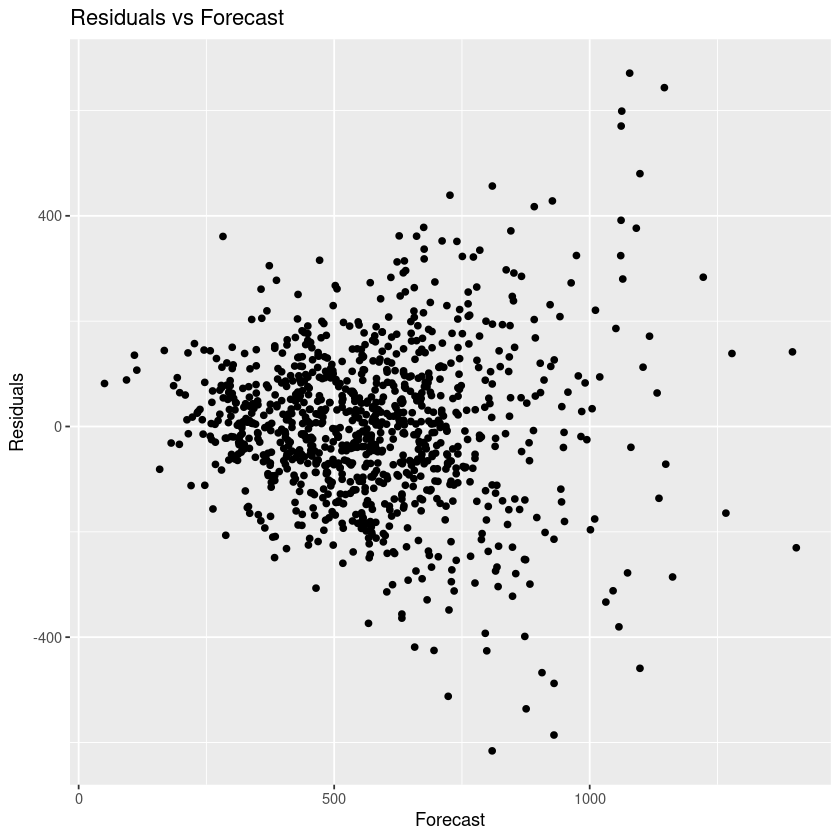

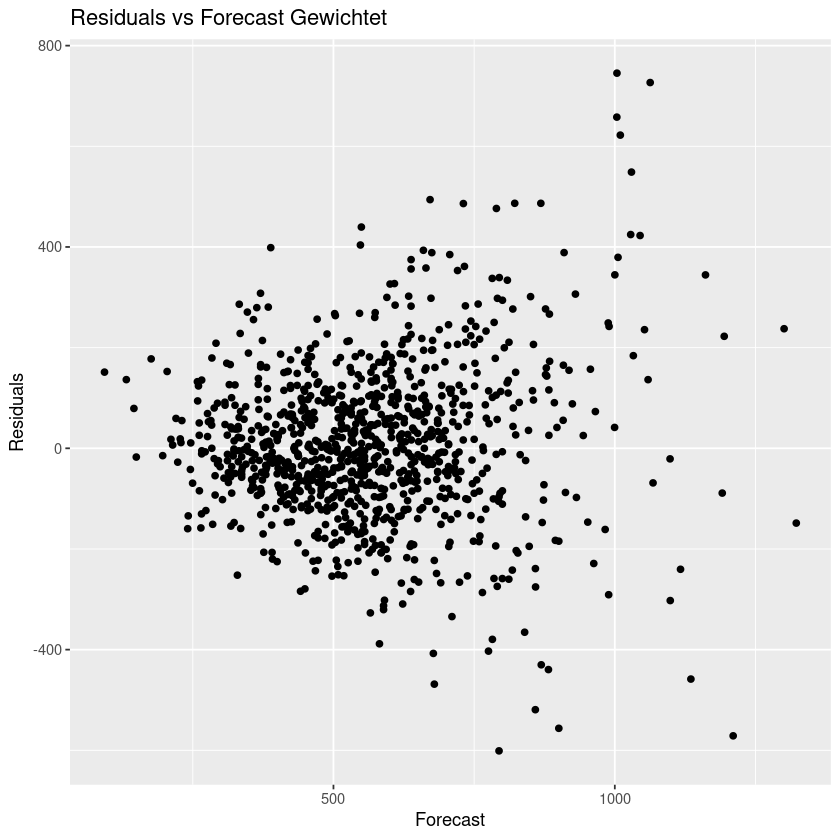

In [32]:
test_lin <- data.frame(Residuals = best_model$residuals, Fitted = best_model$fitted.values)
ggplot(test_lin, aes(x = Fitted, y = Residuals)) + geom_point() + labs(title="Residuals vs Forecast", x ="Forecast", y = "Residuals")
wt <- 1 / lm(abs(best_model$residuals) ~ best_model$fitted.values)$fitted.values^2
wls <- lm(Rent ~  Area  +  Resid_Complex + Age_Grouped + No_Centr_Heat + Elev_Kitchen + Elev_Bath + No_Centr_Heat + No_Tiled_Bath , data = rent, weights = wt)
ggplot(data.frame(x = wls$fitted.values, y = wls$residuals), aes(x=x, y=y)) + geom_point() + labs(title="Residuals vs Forecast Gewichtet", x ="Forecast", y = "Residuals")

We don't see any significant difference. If we compare the averages of the squared residuals from the normal model 22810 and the weighted 24214 we see that by weighting even deterioration has been achieved. So we stick to the original model.

## Outliers
The model has some statistical outliers. Graphs (a) and (b) compare the residual plots of the models with (a) and without (b) outliers. We see that in (b) the residuals are arranged circularly around zero on the y-axis and around the mean 575. Graph (c) compares the model parameters of the models with and without outliers. The outliers have the strongest effect on the variables "No Warm Water Supply" and "Best Residential Complex". Still, there is no obvious justification for removing the outliers.

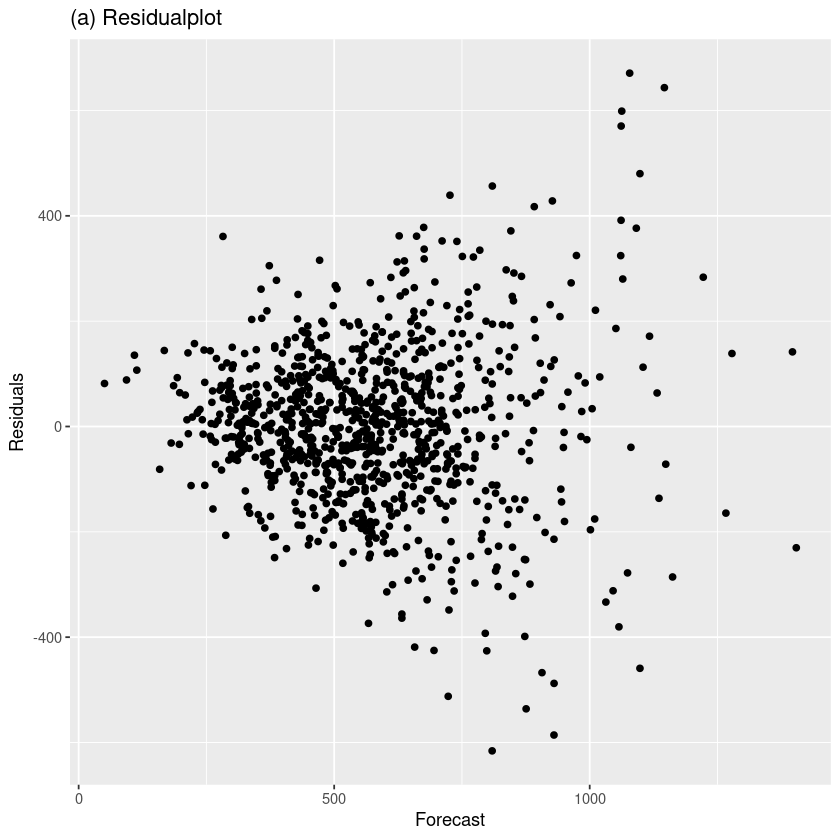

Using X as id variables



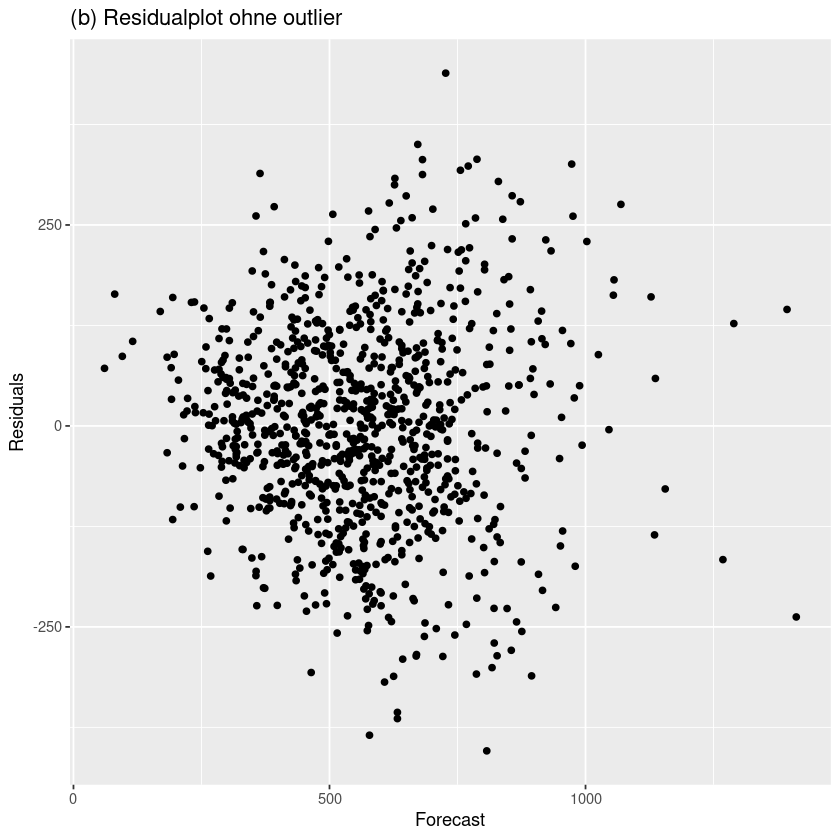

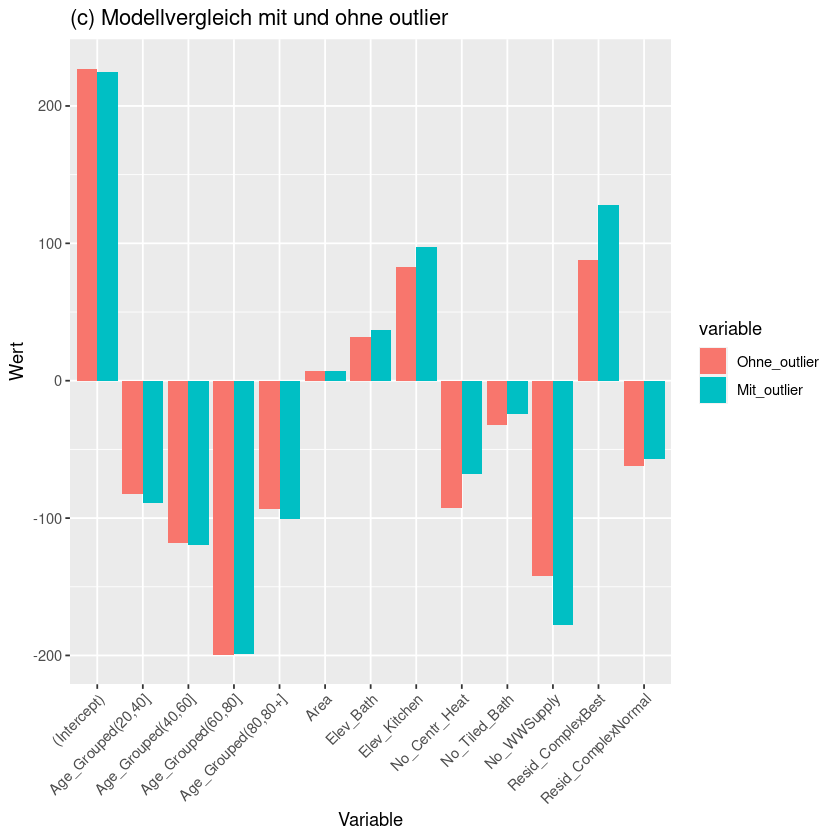

In [33]:
cdist <- cooks.distance(best_model)
outlier <- unique(which(cdist > 4 * mean(cdist)))
best_mod_no_outlier <- lm(Rent ~  ., data = rent[-outlier,-3])

test_best_mod_no_outlier <- data.frame(Residuals = best_mod_no_outlier$residuals, Fitted = best_mod_no_outlier$fitted.values)

ggplot(test_lin, aes(x = Fitted, y = Residuals)) + geom_point() + labs(title="(a) Residualplot", x ="Forecast", y = "Residuals")

ggplot(test_best_mod_no_outlier, aes(x = Fitted, y = Residuals)) + geom_point() + labs(title="(b) Residualplot ohne outlier", x ="Forecast", y = "Residuals")

outlier_cmp <- data.frame(Ohne_outlier = round(best_mod_no_outlier$coefficients,2), Mit_outlier = round(best_model$coefficients,2))
outl <- melt(cbind(X = rownames(outlier_cmp), outlier_cmp))

ggplot(outl, aes(x = X, y= value, fill = variable)) + geom_bar(stat = 'identity', position = "dodge") +
  scale_x_discrete(guide = guide_axis(angle = 45)) + labs(title="(c) Modellvergleich mit und ohne outlier", x ="Variable", y = "Wert")

# Conclusion
Based on the data analysis and the best subset method, different linear models with different complexity were estimated. A decision tree gave us additional information about the hierarchical structure of the variables. From this we could clearly see that living space is the most dominant variable for explaining the net rental price.

The best subset method was used to evaluate which linear model without interactions or further variable transformations is the best. From this procedure a model with all available explanatory variables was chosen. In the next step, this model was supplemented by some interactions originating from the trivariate analysis. This model has a higher explanatory content, but is unusable for the application, since only very few variables are statistically significant. For this reason, an additional model was calculated with only the interactions that were statistically significant from the previous model as an addition to the best subset model. However, this model is worse in its prognosis than the best subset model. For these reasons, the Best Subset model was chosen as the final model.

In the last step, the model was tested for violating the homogeneity of variance and for the influence of outliers. The model has unequal variances in the errors. This phenomenon does not affect the coefficients themselves, but rather their variance. As a consequence, there is theoretically another estimator with less variance. Finding this should be achieved by a weighted linear model. In this model, observations with higher variance are given less weight and thus contribute less to the result. However, this model leads to a higher residual variance, which means that this method is also rejected. Outliers in the model were identified using the Cook's distance criterion. In the following, the best subset model was estimated once with and once without outliers and the results compared with each other. No particularly noticeable changes in the model came to light here. More importantly, however, there are no obvious reasons to remove outliers. For this reason, the model with outliers was also chosen here.

A decision was made against other transformations of variables, such as the calculation of square meter prices, due to application reasons. This model, as is, can be used directly on each new observation of the shape of the data set to estimate the net rent.

Based on all analyzes made, a decision is made in favor of a linear regression model with all variables present, excluding the number of rooms, without interactions to explain the net rental price.